<font color='purple'> **Проект: "Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru"**</font>

***План работы:***

  1) Предварительный осмотр данных: загрузка, краткий вывод, удаление дубликатов, изменения типов данных (по необходимости)
  2) Разведовательный анализ данных, работа с пропусками, объединение таблиц.
  3) Отбор существующих и генерация новых признаков для итогового датасета.
  4) Подбор, обучение и валидация моделей.
  5) Тестирование лучшей модели на тестовом наборе.
  6) Общие выводы по проекту.

In [479]:
#если будет ошибка закрузки TargetEncoder из sklearn.preprocessing нужно разкомментировать эту строку
#%pip install -U scikit-learn

In [480]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, Text
from tqdm.auto import tqdm
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import TargetEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
import shap

In [481]:
sns.set_style('whitegrid')
sns.set_palette('bright', n_colors=20)
warnings.filterwarnings('ignore')

In [482]:
random_state = 42

***1. Предварительный осмотр данных.***
- в данном разделе я буду поочередно загружать датасеты и проводить с ними операции по предварительной предобработке.
- при изменении датасетов буду ставить коммент предобработка
- ***Датасет "Заявки":***

In [483]:
try:
    orders = pd.read_feather('/datasets/orders.feather')
except:    
    orders = pd.read_feather('/Users/maiiayakusheva/Downloads/datasets/orders.feather')

In [484]:
orders.sample(1)

id               order_date  subject_id purpose  lesson_price  \
54903  2453535  2023-01-31 14:23:16.667         2.0    None             0   

       lesson_duration lesson_place  home_metro_id add_info start_date  ...  \
54903               60         None            NaN     None       None  ...   

       chosen_teachers_only  no_teachers_available source_id  \
54903                     0                      0         8   

       original_order_id client_id  additional_status_id max_metro_distance  \
54903                NaN   1086191                   5.0                NaN   

       estimated_fee  payment_date  is_display_to_teachers  
54903           None          None                       1  

[1 rows x 38 columns]

In [485]:
orders.duplicated().sum()

900

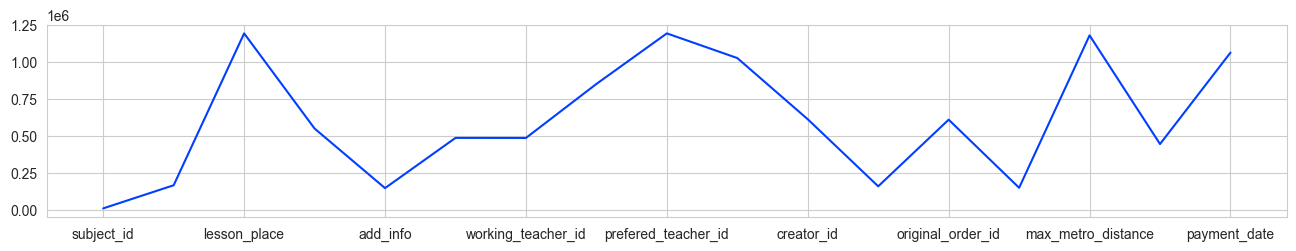

In [486]:
orders.isna().sum()[orders.isna().sum()!=0].plot(figsize=(16, 2.5));

In [487]:
orders.isna().sum().sum()

10320506

In [488]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

In [489]:
num_ord = []
cat_ord = []
for x in orders.columns:
    if orders[x].dtype == 'object':
        cat_ord.append(x)
    else:
        num_ord.append(x)
print("Численный тип данных:", len(num_ord), "cтроковый тип данных:", len(cat_ord))

Численный тип данных: 28 cтроковый тип данных: 10


In [490]:
orders.shape

(1191861, 38)

- Загружен датасет с заявками пользователей, содержащий в себе 38 колонок и 1191861 записей. Из них 10 имеют строковый, 28 - численный тип данных. В датасете есть 900 дубликатов  и в общей сложности 10320506 пропусков.
- Удалю полные дубликаты строк, приведу временные признаки к временному типу данных(так как в этих данных есть много опечаток поставлю метод обработки ошибки 'coerce', потом может быть получится восстановить даты, изходя из данного датасета это невозможно, так как все временные столбцы имеют аналогичные ошибки).

In [491]:
orders[orders.id==2398558]

id               order_date  subject_id  \
104493  2398558  2023-01-07 00:00:12.137        19.0   
0       2398558  2023-01-07 00:00:12.137        19.0   

                                                  purpose  lesson_price  \
104493  Разделы: вокал.\nКатегория ученика: парень 27 ...          1200   
0       Разделы: вокал.\nКатегория ученика: парень 27 ...          1200   

        lesson_duration lesson_place  home_metro_id  \
104493               60         None         1630.0   
0                    60         None         1630.0   

                                                 add_info  \
104493  Район: г. Кондрово.\nМесто проведения занятий:...   
0       Район: г. Кондрово.\nМесто проведения занятий:...   

                     start_date  ...  chosen_teachers_only  \
104493  2023-01-07 12:17:22.070  ...                     0   
0       2023-01-07 12:17:22.070  ...                     0   

        no_teachers_available source_id  original_order_id client_id  \
104493                      0        23                NaN   1062677   
0                           0        23                NaN   1062677   

        additional_status_id max_metro_distance  estimated_fee  payment_date  \
104493                  21.0                NaN           3240          None   
0                       21.0                NaN           3240          None   

        is_display_to_teachers  
104493                       1  
0                            1  

[2 rows x 38 columns]

In [492]:
#предобработка
orders.drop_duplicates(inplace=True)

In [493]:
orders.shape

(1190961, 38)

In [494]:
#предобработка
orders.order_date = pd.to_datetime(orders.order_date, errors= 'coerce')
orders.start_date = pd.to_datetime(orders.start_date, errors= 'coerce')
orders.first_lesson_date = pd.to_datetime(orders.first_lesson_date, errors= 'coerce')
orders.payment_date = pd.to_datetime(orders.payment_date, errors= 'coerce')

- ***Датасет "Репетиторы":***

In [495]:
try:
    teachers = pd.read_feather('/datasets/teachers_info.feather')
except:    
    teachers = pd.read_feather('/Users/maiiayakusheva/Downloads/datasets/teachers_info.feather')

In [496]:
teachers.sample(1)

id              date_update                 reg_date  \
33792  35099  2023-01-19 19:20:14.233  2012-01-04 23:25:50.000   

                    birth_date      teaching_start_date  user_id  \
33792  1961-01-28 00:00:00.000  1986-01-01 00:00:00.000    36211   

       is_email_confirmed  is_home_lessons  is_external_lessons  \
33792                   0                1                    1   

         external_comments  ...  verification_status_id  is_individual  \
33792  Любой район Москвы.  ...                       1            NaN   

       partner_id star_rating  rating_for_users_yesterday  review_num  \
33792         NaN    4.300781                         0.0           0   

                relevance_date  is_display_at_partners  status_institution_id  \
33792  2017-01-01 00:00:00.000                       1                    NaN   

      free_time_relevance_date  
33792                      NaN  

[1 rows x 80 columns]

In [497]:
teachers.duplicated().sum()

0

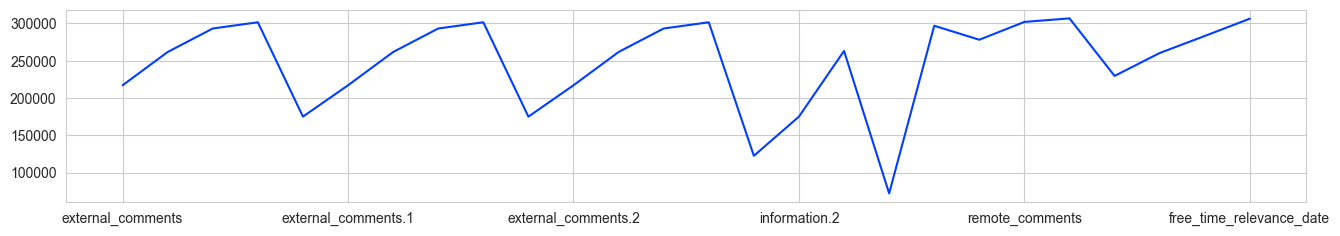

In [498]:
teachers.isna().sum()[teachers.isna().sum()!=0].plot(figsize=(16, 2.5));

In [499]:
teachers.isna().sum().sum()

6464515

In [500]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

In [501]:
num_teach = []
cat_teach = []
for x in teachers.columns:
    if teachers[x].dtype == 'category':
        cat_teach.append(x)
    else:
        num_teach.append(x)
print("Численный тип данных:", len(num_teach), "cтроковый тип данных:", len(cat_teach))

Численный тип данных: 58 cтроковый тип данных: 22


In [502]:
teachers.shape

(307972, 80)

- Загружен датасет с информацией об учителях, содержащий в себе 80 колонок и 307972 записей. Из них 22 имеют строковый, 58 - численный тип данных. В датасете есть 0 дубликатов  и в общей сложности 6464515 пропусков.
- Приведу временные признаки к временному типу данных.

In [503]:
#предобработка
teachers.date_update = pd.to_datetime(teachers.date_update)
teachers.reg_date = pd.to_datetime(teachers.reg_date)
teachers.birth_date = pd.to_datetime(teachers.birth_date)
teachers.teaching_start_date = pd.to_datetime([x[:10] for x in teachers.teaching_start_date])
teachers.rules_confirmed_date = pd.to_datetime([x[:10] for x in teachers.rules_confirmed_date])
teachers.relevance_date = pd.to_datetime([x[:10] for x in teachers.relevance_date])

In [504]:
#при следующей необходимости работы с этим столбцом, нужно учесть некорректно заполненные даты
teachers.teaching_start_date[teachers.teaching_start_date.dt.year<1950].shape

(7059,)

***Датасет: "Подходящие по фильтру репетиторы:"***

In [505]:
try:
    teachers_filtr = pd.read_feather('/datasets/suitable_teachers.feather')
except:
    teachers_filtr =  pd.read_feather('/Users/maiiayakusheva/Downloads/datasets/suitable_teachers.feather')

In [506]:
teachers_filtr.sample(1)

teacher_id  order_id contact_result  enable_auto_assign  \
10749016      113026   2593750            NaN                   0   

          enable_assign  
10749016              0

In [507]:
teachers_filtr.duplicated().sum()

49

In [508]:
teachers_filtr.isna().sum().to_frame(name='итого пропусков:')

итого пропусков:
teacher_id                         0
order_id                           0
contact_result              12824362
enable_auto_assign                 0
enable_assign                      0

In [509]:
teachers_filtr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


- датасет содержит 5 столбцов и 20271186 строк. 4 столбца численного типа, 1 категориального. Есть 49 дубликатов, которые будут удалены, пропусков 12824362 в столбце результат контакта. 

In [510]:
teachers_filtr.shape

(20271186, 5)

In [511]:
#предобработка
teachers_filtr.drop_duplicates(inplace=True)

In [512]:
teachers_filtr.shape

(20271137, 5)

***2. Разведовательный анализ данных:***
  - сначала буду работать с каждой табличкой отдельно, потом объединю в одну таблицу, сделаю выводы. Так как мы имеем достаточно большое количество признаков буду разделять их на группы, анализировать каждую, по необходимости и возможности удалять/заполнять пропуски/выбросы, если таковые будут.
  
***Датасет "Заявки:***

  - Распределение временных признаков:

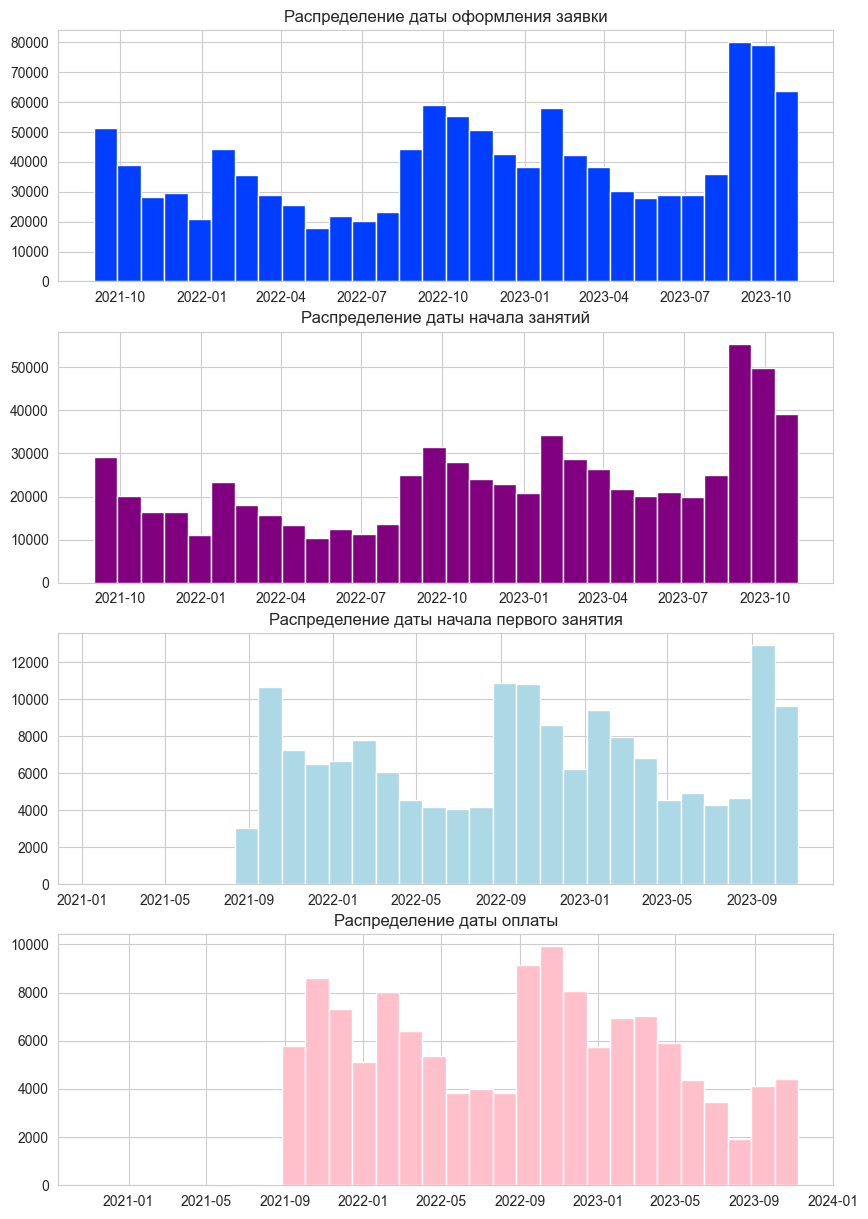

In [513]:
plt.figure(figsize=(10, 15))
plt.subplot(411)
orders.order_date.sort_values().hist(bins=30)
plt.title('Распределение даты оформления заявки')
plt.subplot(412)
orders.start_date.sort_values().hist(color='purple', bins=30)
plt.title('Распределение даты начала занятий')
plt.subplot(413)
orders[orders.first_lesson_date.dt.year>=2021].first_lesson_date.sort_values()\
    .hist(color='lightblue', bins=30)
plt.title('Распределение даты начала первого занятия')
plt.subplot(414)
orders.payment_date.sort_values().hist(color='pink', bins=30)
plt.title('Распределение даты оплаты')
plt.show()

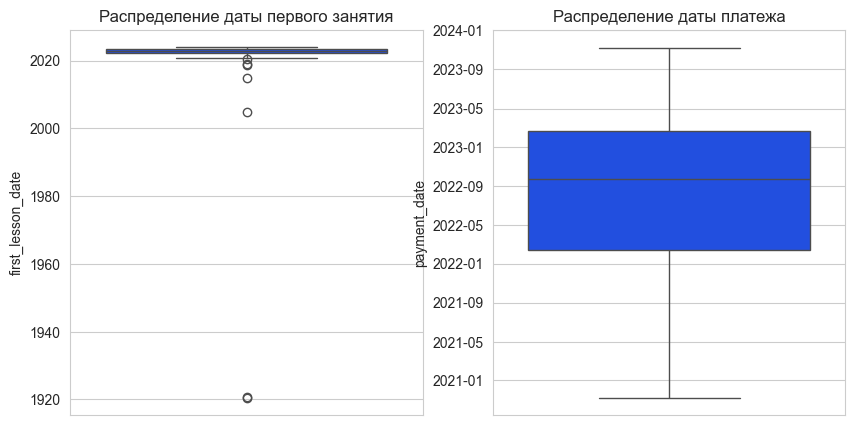

In [514]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxplot(orders.first_lesson_date, ax=axs[0]).set_title('Распределение даты первого занятия')
sns.boxplot(orders.payment_date, ax=axs[1]).set_title('Распределение даты платежа')
plt.show()

- по визуализации даты оформления заявок на обучение мы видим, что максимальные пики приходятся на начало осени, либо на начало года ("осенние" значения больше), аналогичная ситуация и с датами начала занятий, и с датами первого занятия, в принципе схожая ситуация из датами платежей, но на последнем графике мы видим сравнительно небольшой их рост в сентябре-октябре 2023 года, по сравнению с аналогичными периодами за 2021-2022гг
- согласно данным столбцов дата создания заявки и дата начала, временной отчет начинается с 1 сентября 2021 года, заканчивается 5-7 ноября 2023г., но в столбцах с датой начала первого занятия (мин значения) и дата платежа (мin значения) есть несоотвествующие значения:
  - в этих столбцах установлю мин порог 01.09.21 год, все неподходящие значения заполню значениями из соответствующих строк столбца дата начала
- необходимо удалить строки, id которых равно 3211265, 3342337, 3605505, так как оно задублировано в других численных признаках, возможно было бы сохранить эти строки, но в них кроме этой информации, только "выбросы" и пропуски


In [515]:
orders.order_date.min()

Timestamp('2021-09-01 00:12:16.713000')

In [516]:
orders.first_lesson_date.min()

Timestamp('1920-08-02 00:00:00')

In [517]:
orders.payment_date.min()

Timestamp('2020-11-07 20:29:48.167000')

In [518]:
#предобработка
orders['temp'] = np.where((orders.first_lesson_date < '2021-09-01'),
 orders.order_date, orders.first_lesson_date)
orders.drop('first_lesson_date', axis=1, inplace=True)
orders = orders.rename(columns={'temp':'first_lesson_date'})
orders['temp'] = np.where((orders.payment_date < '2021-09-01'),
 orders.order_date, orders.payment_date)
orders.drop('payment_date', axis=1, inplace=True)
orders = orders.rename(columns={'temp':'payment_date'})

In [519]:
orders[(orders.id == 3211265)|(orders.id==3342337)|(orders.id==3605505)]

id order_date  subject_id purpose  lesson_price  lesson_duration  \
105390  3211265        NaT   3211265.0    None       3211265          3211265   
109392  3342337        NaT   3342337.0    None       3342337          3342337   
437216  3605505        NaT   3605505.0    None       3605505          3605505   

       lesson_place  home_metro_id add_info start_date  ...  \
105390         None      3211265.0     None        NaT  ...   
109392         None      3342337.0     None        NaT  ...   
437216         None      3605505.0     None        NaT  ...   

        no_teachers_available  source_id original_order_id  client_id  \
105390                      1    3211265         3211265.0    3211265   
109392                      1    3342337         3342337.0    3342337   
437216                      1    3605505         3605505.0    3605505   

       additional_status_id  max_metro_distance           estimated_fee  \
105390            3211265.0           3211265.0  8,344264636103745E-308   
109392            3342337.0           3342337.0  8,344239172283769E-308   
437216            3605505.0           3605505.0  4,450342944189884E-308   

        is_display_to_teachers  first_lesson_date  payment_date  
105390                       1                NaT           NaT  
109392                       1                NaT           NaT  
437216                       1                NaT           NaT  

[3 rows x 38 columns]

In [520]:
orders.shape

(1190961, 38)

In [521]:
#предобработка
orders = orders[(orders.id != 3211265)&(orders.id!=3342337)&(orders.id!=3605505)]

In [522]:
orders.shape

(1190958, 38)

In [523]:
order_d = orders[orders.start_date.isna()==0].order_date.dt.round('D')
start_d = orders[orders.start_date.isna()==0].start_date.dt.round('D')
pd.Series(order_d==start_d).value_counts().to_frame()

count
True   492885
False  212213

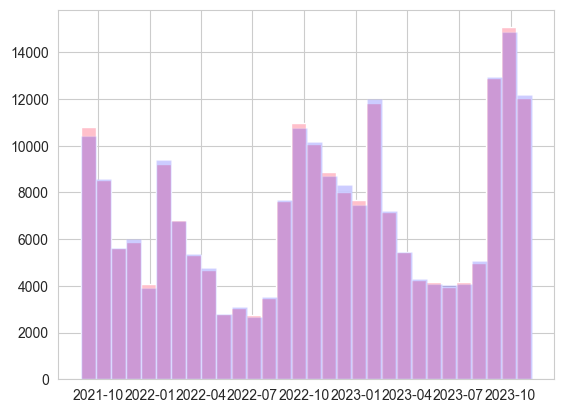

In [524]:
orders[(orders.start_date.isna()==0)&(orders.order_date.dt.round('D')!=orders.start_date.dt.round('D'))]\
    ['order_date'].hist(color='pink', bins=30)
orders[(orders.start_date.isna()==0)&(orders.order_date.dt.round('D')!=orders.start_date.dt.round('D'))]\
    ['start_date'].hist(color='blue', alpha=0.2, bins=30);

Обработка пропущенных значений в столбцах временного типа:

In [525]:
orders[['order_date', 'start_date', 'first_lesson_date', 'payment_date']].isna().sum()

order_date                 0
start_date            485860
first_lesson_date    1024519
payment_date         1061402
dtype: int64

- столбец start_date практически дублирует столбец с датой оформления заявки, значения который не равны ей, отличаются на несколько часов, также в этом столбце содержится большое количество пропусков. По информации от заказчика - это дата назначения репетитора на заявку, была мысль сделать из него бинарный столбец (назначен/не назначен), но по данным заказчика операторы назначают репов на гораздо большее количество заявок, соответственно восстановить эти данные не получится и этот столбец я удалю.
- есть пропуски в столбцах дата начала первого занятия и дата платежа, видимо они обусловлены тем, что по этим заявкам не было занятий/оплаты, но ***пока*** я не буду закрывать их заглушками, так потеряется временной тип данных, который мне в дальнейшем возможно понадобится для создания новых признаков на основании временных отметок.

In [526]:
#предобработка
orders.drop('start_date', axis=1, inplace=True)

- Анализ численных признаков:

Распределение некоторых численных признаков:


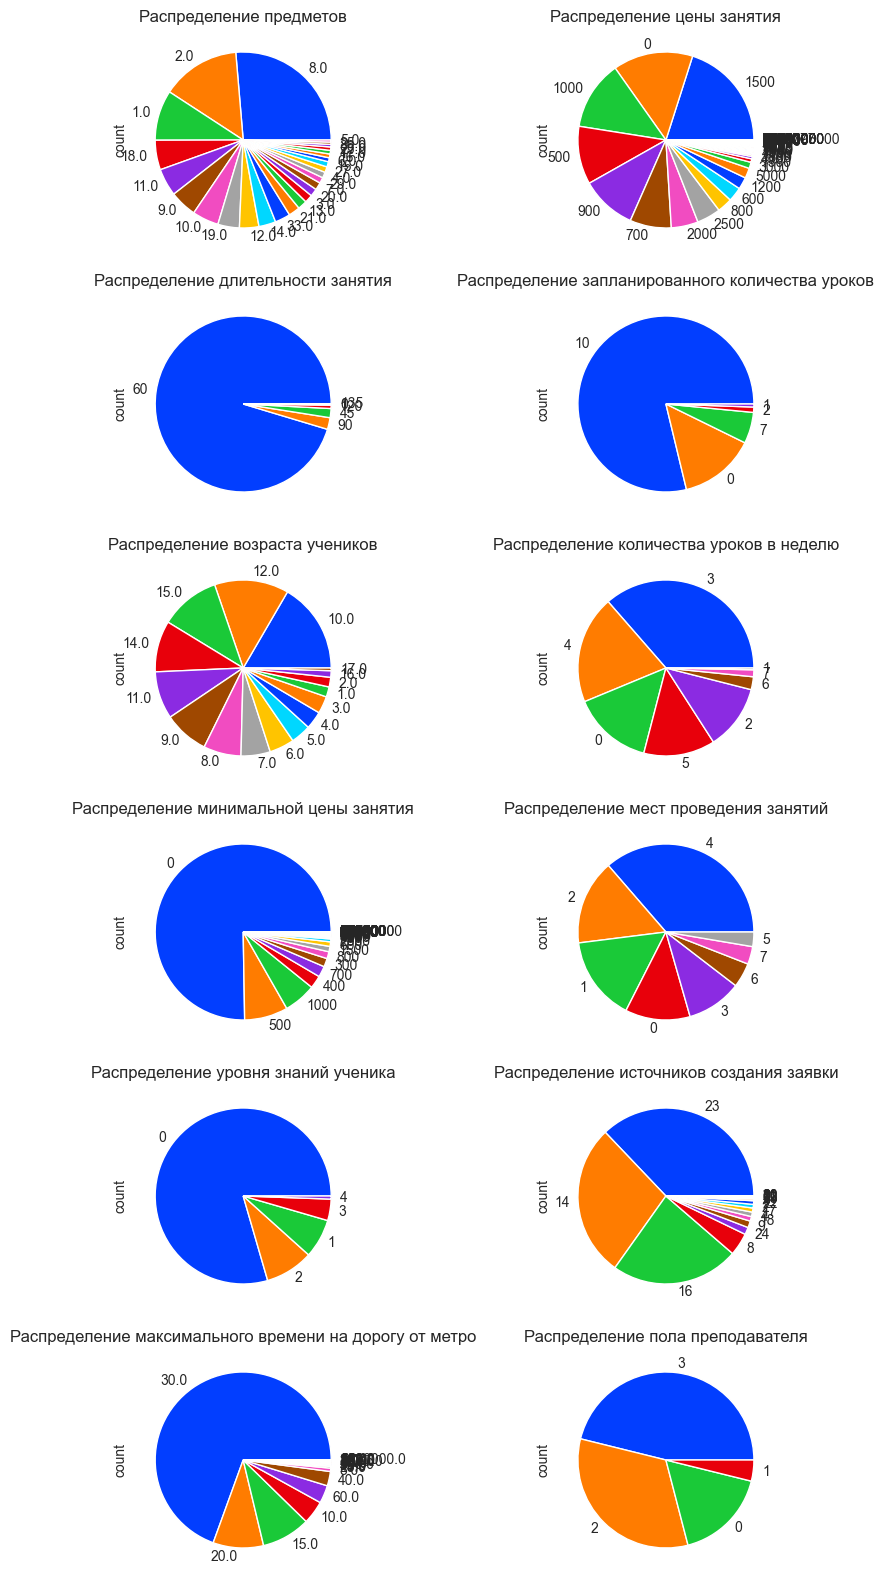

In [527]:
print('Распределение некоторых численных признаков:')
fig, axs = plt.subplots(figsize=(10, 20), nrows=6, ncols=2)
orders.subject_id.value_counts().plot(kind='pie', ax=axs[0,0]).set_title('Распределение предметов')
orders.lesson_price.value_counts().plot(kind='pie', ax=axs[0,1]).set_title('Распределение цены занятия')
orders.lesson_duration.value_counts().plot(kind='pie', ax=axs[1,0])\
    .set_title('Распределение длительности занятия')
orders.planned_lesson_number.value_counts().plot(kind='pie', ax=axs[1,1])\
    .set_title('Распределение запланированного количества уроков')
orders.pupil_category_new_id.value_counts().plot(kind='pie', ax=axs[2,0])\
    .set_title('Распределение возраста учеников')
orders.lessons_per_week.value_counts().plot(kind='pie', ax=axs[2,1])\
    .set_title('Распределение количества уроков в неделю')
orders.minimal_price.value_counts().plot(kind='pie', ax=axs[3,0])\
    .set_title('Распределение минимальной цены занятия')
orders.lesson_place_new.value_counts().plot(kind='pie', ax=axs[3,1])\
    .set_title('Распределение мест проведения занятий')
orders.pupil_knowledgelvl.value_counts().plot(kind='pie', ax=axs[4,0])\
    .set_title('Распределение уровня знаний ученика')
orders.source_id.value_counts().plot(kind='pie', ax=axs[4,1])\
    .set_title('Распределение источников создания заявки')
orders.max_metro_distance.value_counts().plot(kind='pie', ax=axs[5,0])\
    .set_title('Распределение максимального времени на дорогу от метро')
orders.teacher_sex.value_counts().plot(kind='pie', ax=axs[5,1])\
    .set_title('Распределение пола преподавателя')
plt.show()

Выводы по визуализации:
- распределение предметов обучения: лидируют предметы, закодированные цифрами 8, 2, 1. Пропуски закрою заглушкой 0
- распределение цены занятия: лидируют 1500, 1000, 500, 0. На визуализации видна вероятность выбросов в этом столбце, ниже посмотрю его в boxplot. Также значение 0 говорит видимо о незаполненном поле в данном случае
- распределение длительности занятия: безоговорочно лидирует 60 минут
- распределение количества запланированных уроков: лидирует 10 уроков
- распределение возраста учеников: лидируют возраста, относящиеся к средней школе(странно почему нет 13 лет)
- распределение количества уроков в неделю: лидируют - 3, 4, 5, 0.
- распределение минимальной цены занятия: лидирует 0. На визуализации вида вероятность выбросов в этом столбце, ниже посмотрю его в boxplot
- распределение мест проведения занятий: лидируют значения - 4, 2, 1
- распределение уровня знаний ученика: лидирует нулевой уровень.
- распределение источников создания заявки: лидируют - 23, 14, 16.
- распределение максимального времени до метро: лидируют 30, 20, 15. На визуализации вида вероятность выбросов в этом столбце, ниже посмотрю его в boxplot
- пол репетитора: по данным заказчика значение 1 - мужской, 2-женский, 0 и 3 -"пол неизвестен", изменим этот столбец установив единое значение 0 для неизвестных значений

In [528]:
#предобработка
orders.subject_id = orders.subject_id.fillna(0)
orders.teacher_sex = [1 if x==1 else 2 if x==2 else 0 for x in orders.teacher_sex]

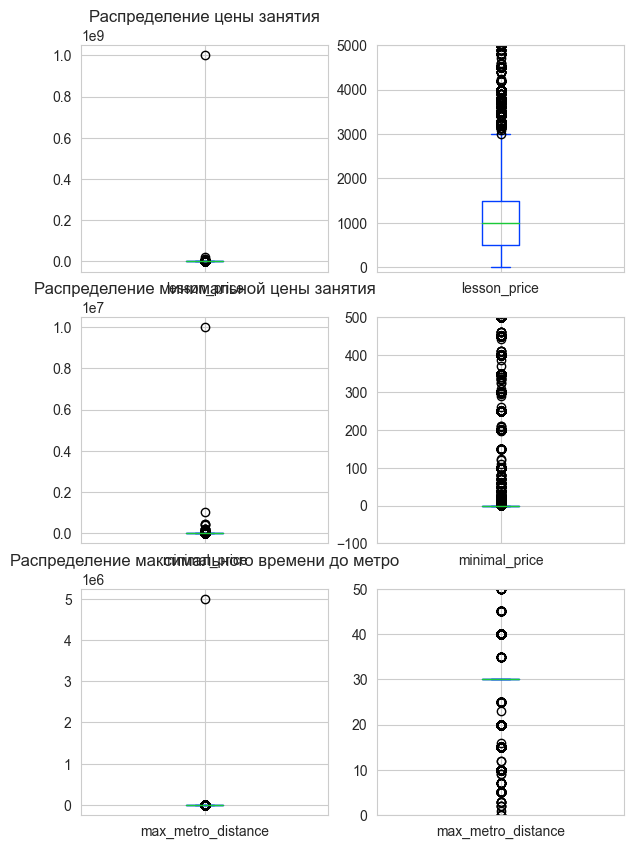

In [529]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(7, 10))
font_size=10
orders.lesson_price.plot.box(fontsize=font_size, ax=axs[0,0])\
    .set_title('Распределение цены занятия')
orders.lesson_price.plot.box(fontsize=font_size, ax=axs[0,1])\
    .set_ylim(-100, 5000)
orders.minimal_price.plot.box(fontsize=font_size, ax=axs[1,0])\
    .set_title('Распределение минимальной цены занятия')
orders.minimal_price.plot.box(fontsize=font_size, ax=axs[1,1])\
    .set_ylim(-100, 500)
orders.max_metro_distance.plot.box(fontsize=font_size, ax=axs[2,0])\
    .set_title('Распределение максимального времени до метро')
orders.max_metro_distance.plot.box(fontsize=font_size, ax=axs[2,1])\
    .set_ylim(0, 50)
plt.show()

In [530]:
orders[orders.lesson_price>100000].lesson_price.sort_values(ascending=False).head()

21341     1000000000
81022       20000000
94824       10090000
363192      10000000
292373       7777777
Name: lesson_price, dtype: int32

In [531]:
orders[orders.minimal_price>100000].minimal_price.sort_values(ascending=False).head()

363192    10000000
183112     1000000
47071       450000
49347       450000
69295       400000
Name: minimal_price, dtype: int32

In [532]:
orders[orders.max_metro_distance>100].max_metro_distance.sort_values(ascending=False).to_frame().head(10)

max_metro_distance
318203           5000000.0
320389              3000.0
343067              3000.0
343025              3000.0
332314              3000.0
320957              3000.0
47582                500.0
310130               180.0
51145                158.0
51342                158.0

In [533]:
orders[orders.pupil_category_new_id<4][['pupil_category_new_id', 'purpose']]

pupil_category_new_id  \
23                        2.0   
40                        1.0   
113                       3.0   
149                       2.0   
151                       3.0   
...                       ...   
437172                    2.0   
437181                    1.0   
437188                    2.0   
437192                    3.0   
437214                    2.0   

                                                  purpose  
23      Разделы: математика.\nКатегория ученика: школь...  
40      Разделы: общий курс.\nКатегория ученика: ребен...  
113     \n​Разделы :  школьный курс \n​Цель занятий : ...  
149     Разделы:  школьный курс.\nКатегория ученика: ш...  
151     Разделы: общий курс.\nКатегория ученика: школь...  
...                                                   ...  
437172  Разделы: общий курс.\nКатегория ученика: школь...  
437181  Разделы: подготовка к школе.\nКатегория ученик...  
437188  Разделы: гимнастика.\nКатегория ученика: школь...  
437192  Разделы:  школьный курс.\nКатегория ученика: ш...  
437214  Разделы: общий курс.\nКатегория ученика: 1 кла...  

[70083 rows x 2 columns]

-  итак:
  - в категориях  с минимальной ценой занятия, ценой занятия и максимальным расстоянием до метро присутствую выбросы. По данным от заказчика цена занятия не может быть более 10000, а время ограничу 100 минутами, заменю выбросы на медианные значения по категории
  - нулевые значения в полях: количество уроков в неделю, цена занятия и минимальная цена занятия говорят о том, что данные столбцы просто не были заполнены - закрою их медианными значениями по категории, а нули в столбце с минимальной ценой вторым по популярности значением, так как медианна или мода там нулевая
  - заменю выбросы в графе возраст ученика (по крайней мере до 5 лет) на медианные значения по категории

In [534]:
#предобработка выбросов
orders.loc[orders.max_metro_distance > 100, 'max_metro_distance'] = orders.max_metro_distance.median()
orders.loc[orders.minimal_price > 10000, 'minimal_price'] = orders.minimal_price.median()
orders.loc[orders.lesson_price > 10000, 'lesson_price'] = orders.lesson_price.median()
orders.loc[orders.lessons_per_week == 0, 'lessons_per_week'] = orders.lessons_per_week.median()
orders.loc[orders.minimal_price == 0, 'minimal_price'] = orders.minimal_price.value_counts().index[1]
orders.loc[orders.lesson_price == 0, 'lesson_price'] = orders.lesson_price.median()
orders.loc[orders.pupil_category_new_id < 5, 'pupil_category_new_id'] = orders.pupil_category_new_id\
    .median()

- Работа с пропусками:
  - пропуске есть в данных о возрасте ученика и максимальной дистанцией до метро, заполню их медианным значением по категории.

In [535]:
orders[['subject_id', 'lesson_price', 'lesson_duration', 'planned_lesson_number', 'pupil_category_new_id',
    'lessons_per_week', 'minimal_price', 'lesson_place_new', 'pupil_knowledgelvl', 'source_id',
    'max_metro_distance']].isna().sum().to_frame(name='итого пропусков:')

итого пропусков:
subject_id                            0
lesson_price                          0
lesson_duration                       0
planned_lesson_number                 0
pupil_category_new_id            159306
lessons_per_week                      0
minimal_price                         0
lesson_place_new                      0
pupil_knowledgelvl                    0
source_id                             0
max_metro_distance              1177457

In [536]:
#предобработка
orders.pupil_category_new_id.fillna(orders.pupil_category_new_id.median(), inplace=True)
orders.max_metro_distance.fillna(orders.max_metro_distance.median(), inplace=True)

- Анализ и обработка второй группы численных признаков:

In [537]:
orders.home_metro_id.nunique()

2323

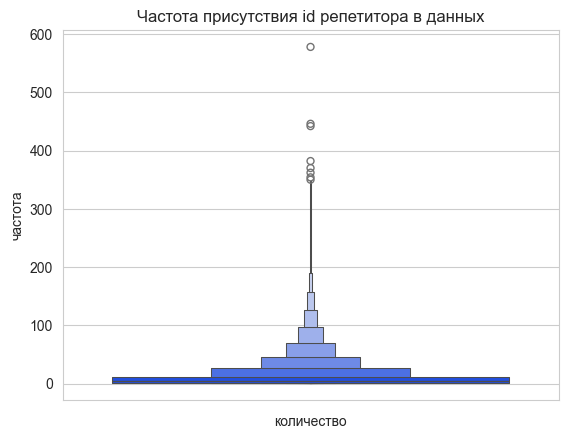

In [538]:
sns.boxenplot(orders.working_teacher_id.value_counts())
plt.title('Частота присутствия id репетитора в данных')
plt.ylabel('частота')
plt.xlabel('количество')
plt.show()

In [539]:
orders.creator_id.value_counts()[orders.creator_id.value_counts()>1].count()

43832

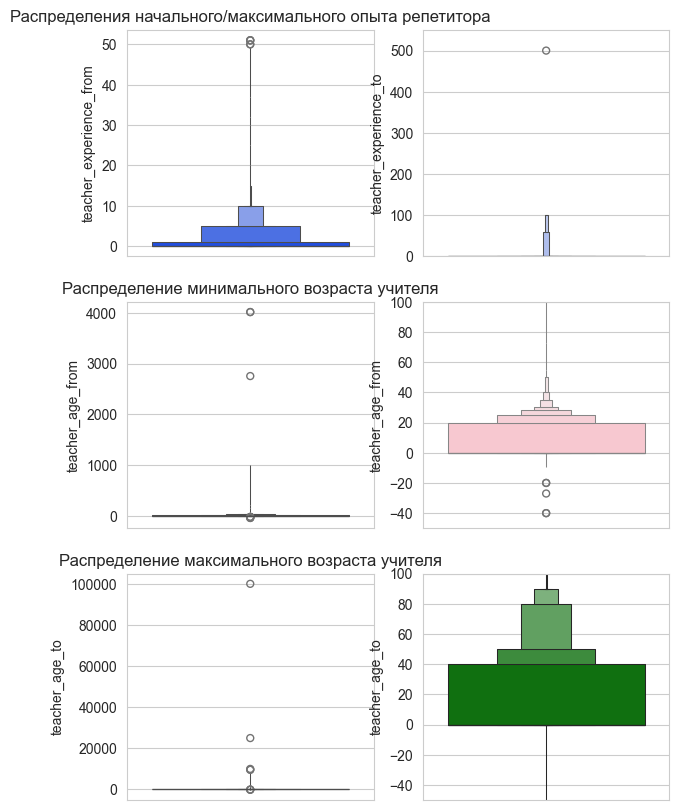

In [540]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(7, 10))
sns.boxenplot(orders.teacher_experience_from, ax=axs[0,0])\
    .set_title('Распределения начального/максимального опыта репетитора')
sns.boxenplot(orders.teacher_experience_to, ax=axs[0,1])\
    .set_ylim(0,550)
sns.boxenplot(orders.teacher_age_from, ax=axs[1,0])\
    .set_title('Распределение минимального возраста учителя')
sns.boxenplot(orders.teacher_age_from, ax=axs[1,1], color='pink')\
    .set_ylim(-50, 100)
sns.boxenplot(orders.teacher_age_to, ax=axs[2,0])\
    .set_title('Распределение максимального возраста учителя')
sns.boxenplot(orders.teacher_age_to, ax=axs[2,1], color='green')\
    .set_ylim(-50, 100)
plt.show()

In [541]:
orders.teacher_experience_to.value_counts().to_frame(name='частота распределение начального опыта учителя')

частота распределение начального опыта учителя
teacher_experience_to                                                
0                                                             1173758
100                                                              4901
50                                                               3426
10                                                               1933
60                                                               1457
...                                                               ...
2                                                                   1
99                                                                  1
26                                                                  1
9                                                                   1
500                                                                 1

[65 rows x 1 columns]

In [542]:
orders[(orders.teacher_age_from<18)|(orders.teacher_age_from>80)].status_id.value_counts()\
    .to_frame(name='Распределение таргета на выбросы в мин возрасте учителя')

Распределение таргета на выбросы в мин возрасте учителя
status_id                                                         
16                                                    543924      
7                                                     171840      
6                                                      73368      
14                                                     19923      
8                                                       7433      
11                                                      6666      
12                                                      3141      
15                                                      3133      
3                                                       3018      
13                                                      1912      
4                                                       1748      
9                                                        967      
5                                                        275      
1                                                         96      
2                                                          3

In [543]:
orders.chosen_teachers_only.value_counts().to_frame(name='Распределение выбора конкретного учителя')

Распределение выбора конкретного учителя
chosen_teachers_only                                          
0                                                      1164322
1                                                        26636

In [544]:
orders.no_teachers_available.value_counts()\
    .to_frame(name='Распределение данных об осутствии учителей на заявку')

Распределение данных об осутствии учителей на заявку
no_teachers_available                                                      
0                                                                1082753   
1                                                                 108205

In [545]:
orders[orders.no_teachers_available==1].status_id.value_counts()\
    .to_frame(name='Распределение таргета для заявок с отсутствием подходящих учителей')

Распределение таргета для заявок с отсутствием подходящих учителей
status_id                                                                    
16                                                     96154                 
7                                                       4793                 
3                                                       2891                 
6                                                       2233                 
8                                                        511                 
11                                                       492                 
14                                                       482                 
4                                                        234                 
15                                                       157                 
12                                                       131                 
13                                                        79                 
9                                                         39                 
5                                                          7                 
1                                                          2

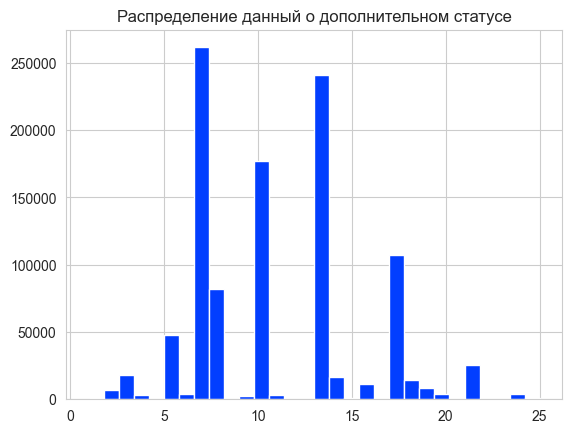

In [546]:
orders.additional_status_id.hist(bins=30)
plt.title('Распределение данный о дополнительном статусе');

In [547]:
orders.is_display_to_teachers.value_counts()\
    .to_frame(name='Распределение данных о согласии клиента на отклики учителей')

Распределение данных о согласии клиента на отклики учителей
is_display_to_teachers                                                             
1                                                                 1148253          
0                                                                   42705

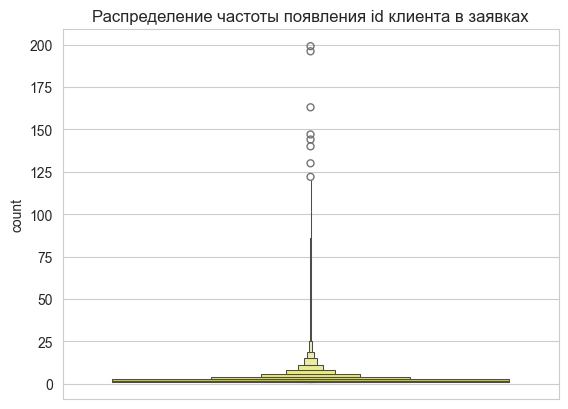

In [548]:
sns.boxenplot(orders.client_id.value_counts(), color='yellow')
plt.title('Распределение частоты появления id клиента в заявках');

In [549]:
orders.original_order_id.value_counts().to_frame(name='Частота оригинальных id заявок')

Частота оригинальных id заявок
original_order_id                                
1751638.0                                     100
2289774.0                                      92
2353479.0                                      87
2509516.0                                      83
2075564.0                                      79
...                                           ...
2682378.0                                       1
2682389.0                                       1
2682376.0                                       1
2682391.0                                       1
2243958.0                                       1

[314928 rows x 1 columns]

- так как во на территории всей страны насчитывается всего 393 станции метро, а в данном столбце их в 6 раз больше, и восстановить данную информацию не представляется возможным, удалю столбец home_metro_id
- по полученной информации столбцы working_teacher_id и additional_status_id несут в себе информацию из будущего и по этой причине должны быть удалены
- подавляющее количество значений в столбце creator_id встречается 1 раз, значений, встречающихся более 100 раз, всего 83 (скорее всего это сотрудники колл-центра), то есть основную массу заявок регистрируют сами пользователи, пропуски в них заполню заглушкой 0
- распределение данных о начальном опыте репетитора: основное значение - от 0 лет
- распределение данных о максимальном опыте учителя: подавляющее количество имеет значение 0 лет (более миллиона строк - видимо просто эти данные не проставлялись), следующие по популярности значения носят явно "выбросный" характер(100 лет), так как этот столбец не несет никакой информации, я его удалю
- данные о минимальном/максимальном возрасте учителя содержат выбросы, возрастной диапазон ограничу интервалом от 16 до 90 лет, другие значения заполню вторым по популярности ответом клиента
- судя по распределению столбца "не предлагать репетиторов кроме выбранных" основная масса клиентов идет не к конкретному учителю
- судя по данным в столбце "на заявку нет подходящих репетиторов" в большинстве случаев это не так, а те же заявки где значение является положительным в основном закрыты
- по данным о желании клиента получать отклики об учителях: основная чать согласна на это
- согласно визуализации с частотой появления id клиента в заявках, можно сделать вывод, что основная масса потребителей обращается только 1 раз
- столбец prefered_teacher_id состоит из одних пропусков и несет информацию из будущего, удалю его
- столбец с оригинальными id заявок содержит пропуски (что вполне логично, так как не все заявки имеют дубликаты), тогда как некоторые заявки имеют их до 100 штук, я пока буду его никак изменять, так как он будет нужен в дальнейшем для группировок и конечно для анализа), но не для обучения!

In [550]:
#предобработка
orders.loc[(orders.teacher_age_from<16)|(orders.teacher_age_from>90), 'teacher_age_from']\
     = orders.teacher_age_from.value_counts().index[1]
orders.loc[(orders.teacher_age_to<16)|(orders.teacher_age_to>90), 'teacher_age_to']\
     = orders.teacher_age_to.value_counts().index[1]
orders.drop(['home_metro_id', 'teacher_experience_to', 'prefered_teacher_id', 'working_teacher_id',\
    'additional_status_id'], axis=1, inplace=True)
orders.creator_id = orders.creator_id.fillna(0)
orders.shape

(1190958, 32)

- Анализ категориальных признаков:
  - два столбца: "сумма к оплате" и "ориентировочная плата" имеют категориальный тип, сразу переведу их в численный тип (для этого в ориентировочной плате пропуски закрою нолями и немного "почищу" данные)

In [551]:
#предобработка
orders.amount_to_pay = [re.sub(',', '.', x) for x in orders.amount_to_pay]
orders.amount_to_pay = orders.amount_to_pay.astype('float32')
orders.estimated_fee = orders.estimated_fee.fillna('0')
orders.estimated_fee = [re.sub(',', '.', x) for x in orders.estimated_fee]
orders.estimated_fee = orders.estimated_fee.astype('float32')

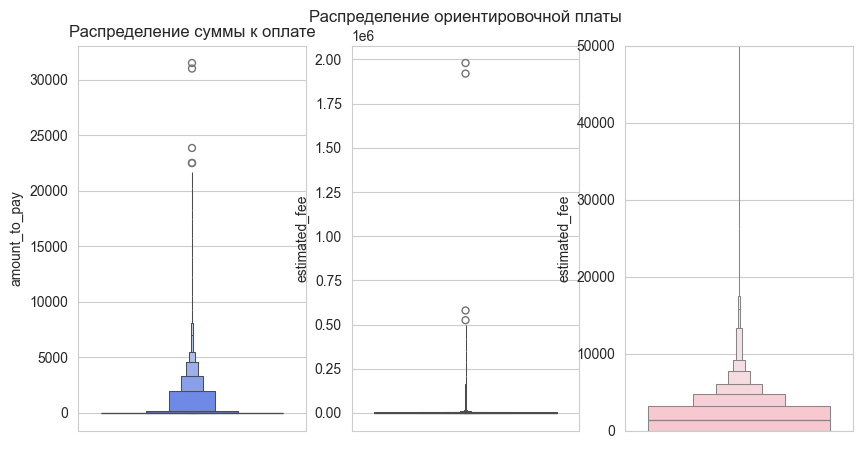

In [552]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
sns.boxenplot(orders.amount_to_pay, ax=axs[0]).set_title('Распределение суммы к оплате')
sns.boxenplot(orders.estimated_fee, ax=axs[1]).set_title('Распределение ориентировочной платы')
sns.boxenplot(orders.estimated_fee, ax=axs[2], color='pink').set_ylim(0, 50000)
plt.show()

- столбец "сумма к оплате": в основном в этом столбце нулевые значения, и только около 13 процентов ненулевые, так что мы можем сделать первые выводы о количестве оплаченных заявок
- в столбце с ориентировочной оплатой присутствуют выбросы, но я о их не буду удалять, так как и этот столбец и предыдущий содержат информацию из будущего и могут стать причиной "даталика", и будут удалены, но пока я их оставлю для анализа данных. В основном этот столбец заполнен нолями (видимо не заполнялся), существующие ожидания от суммы составляют примерно от 1500 до 5000.

- в данном датасете у нас встречаются тектовые данные, например в столбце с целью занятий. Прежде всего в нем нужно заполнить пропущенные значения (заглушка "No"), потом напишу функцию для обработки текста (приведение в нижний регистр, удаление общих и стоп-слов, удаление пунктуации, токенезация и лематизация)
- сначала оценю необходимость оставлять эти данные в итоговом датасете, выведу 10 наиболее часто встречающихся словосочентаний:

In [553]:
FreqDist(Text(orders.purpose)).most_common(10)

[(None, 166420),
 ('Разделы:  школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: подготовка к ОГЭ.',
  11443),
 ('Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо экзамена осталось: Несколько месяцев.\n',
  10586),
 ('Разделы:  школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 11 класса.\nЦель занятий: подготовка к ЕГЭ.',
  9757),
 ('Цели: помощь по школьной программе.\nКатегория ученика: 8 класс.\n', 5678),
 ('Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо экзамена осталось: Год и больше.\n',
  5286),
 ('Цели: помощь по школьной программе.\nКатегория ученика: 7 класс.\n', 5081),
 ('Цели: помощь по школьной программе.\nКатегория ученика: 6 класс.\n', 4309),
 ('Разделы:  школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: сдать ОГЭ.',
  4116),
 ('улучшить оценки', 3816)]

- для данного столбца я применю два способа предобработки:
  - сделаю из него три новых столбца: ***purpose_sections***, содержаший инфо о предметах, ***purpose_categories***, инфо о категориях учеников, ***purpose_lessons***, инфо о целях занятий, соответственно проведу предобработку текстов
  - обработаю этот столбец при помощи паттернов
  - при векторизации текстовых данных соотвественно оставлю один из двух вариантов

In [554]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maiiayakusheva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maiiayakusheva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [555]:
#предобработка 1 вариант
orders.purpose = orders.purpose.fillna('No')
stopwords_ = stopwords.words("russian")
def preprocess_text(text):
    sub_text = [x.lower() for x in text]
    sub_text_ = [re.sub('[^\w\s]', '', x) for x in sub_text]
    tokens = [nltk.word_tokenize(x) for x in sub_text_]
    lemms =  [[nltk.WordNetLemmatizer().lemmatize(y, pos='v') for y in x]for x in tokens]
    clear = [[x.strip() for x in y if x not in stopwords_] for y in lemms]
    text = [', '.join(z) for z in clear]
    return text
orders['purpose_sections'] = orders.purpose.str.split('\n', expand=True).loc[:,0:2].fillna('No')[0]\
    .str.split('Разделы:', expand=True).fillna('No')[1]
orders.purpose_sections = preprocess_text(orders.purpose_sections)
orders['purpose_categories'] = orders.purpose.str.split('\n', expand=True).loc[:,0:2].fillna('No')[1]\
    .str.split('Категория ученика:', expand=True).fillna('No')[1]
orders.purpose_categories = preprocess_text(orders.purpose_categories)
orders['purpose_lessons'] = orders.purpose.str.split('\n', expand=True).loc[:,0:2].fillna('No')[2]\
    .str.split('Цель занятий:', expand=True).fillna('No')[1]
orders.purpose_lessons = preprocess_text(orders.purpose_lessons)

In [556]:
#предобработка 2 вариант
orders.purpose = orders.purpose.fillna('No')
def preprocess_text_patterns(text, pat):
    sub_text = [re.sub(pat, '', x.lower()) for x in text]
    sub_text_ = [re.sub('[^\w\s]', '', x) for x in sub_text]
    tokens = [nltk.word_tokenize(x) for x in sub_text_]
    lemms =  [[nltk.WordNetLemmatizer().lemmatize(y, pos='v') for y in x]for x in tokens]
    text = [', '.join(z) for z in lemms]
    return text
pat_purpose = re.compile('(\n)*(разделы:)*(цели:)*(категория ученика:)*(дополнения:)*(цель занятий:)*'\
    '(уровень знаний:)*(категория ученика:)*')
orders['purpose'] = preprocess_text_patterns(orders.purpose, pat_purpose)

In [557]:
FreqDist(Text(orders.add_info)).most_common(10)

[(None, 147096),
 ('Количество занятий в неделю: 1-2.\nВозраст репетитора: не важно.\nПол репетитора: Не важно.\n',
  7234),
 ('Подстроюсь под репетитора', 7110),
 ('Количество занятий в неделю: 1-2.\nВозраст репетитора: не важно.\nПол репетитора: Женский.\n',
  3715),
 ('Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не имеет значения.',
  2186),
 ('   ', 2136),
 ('Количество занятий в неделю: 1-2.\nОпыт репетитора: не важно.\nВозраст репетитора: не важно.\nПол репетитора: Не важно.\n',
  1971),
 (' Время: Подстроюсь под репетитора;  ', 1912),
 ('Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, по договоренности.\nОпыт репетитора: не имеет значения.\nВозраст репетитора: не имеет значения.\nПол репетитора: не имеет значения.\nСтатус репетитора: не

- столбец с дополнительной информацией в основном содержит в себе дублирующую информацию из других столбцов датасета(опыт, возраст, пол репетитора, формат занятий и т.п.), мною было принято решение его удалить
- относительно столбца с комментариями, в нем около половины пропущенных значений, и в основном служебная информация от операторов колл-центра. Единственным важным элементном в этом столбце я нашла отсылки на оригинальный номер заявки, проверю, возможно он отсутствует в original_order_id, и тогда можно будет восстановить пропущенные значения

In [558]:
#предобработка
orders.comments = orders.comments.fillna('No')
orders['dubl_origin_id'] = pd.Series([''.join(re.findall('\d{7}', x)) for x in orders.comments])
orders.dubl_origin_id = orders.dubl_origin_id.astype(str).replace('', None)

In [559]:
orders.original_order_id.isna().sum()

608721

In [560]:
pd.Series(np.where(orders.original_order_id.isna(), orders.dubl_origin_id, orders.original_order_id))\
    .isna().sum()

541456

- таким образом удается восстановить порядка 60 тыс пропущенных значений в столбце original_order_id. Столбец comment удалю
- так как столбец lesson_place практически полностью состоит из пропусков, удалю его

In [561]:
#предобработка
orders.dubl_origin_id = np.where(orders.original_order_id.isna(), orders.dubl_origin_id,
 orders.original_order_id)
orders.drop(['comments', 'original_order_id', 'lesson_place', 'add_info'], axis=1, inplace=True)
orders = orders.rename(columns={'dubl_origin_id': 'original_order_id'})

- Распределение целевой переменной (столбец status_id):

In [562]:
orders.status_id.value_counts().to_frame(name='Распределение целевого признака')

Распределение целевого признака
status_id                                 
16                                  791756
7                                   212694
6                                   121413
14                                   32933
8                                     8178
11                                    7202
12                                    4731
15                                    3469
3                                     3166
13                                    2111
4                                     1852
9                                     1057
5                                      291
1                                      102
2                                        3

- как видно из таблички выше самую большую частоту занимают значения таргета 16 и 7 (и оба они означают закрытую заявку) - это 84 процента от всего объема. Так как у нас задача бинарной классификации из данного столбца я создам бинарный столбец ***target***, в котором к положительному классу (заявка оплачена) отнесу (по информации от заказчика) значения 5, 6, 13, 15; а к отрицательному все остальные значения. Столбец status_id, соотвественно будет удален.

In [563]:
#предобработка
orders['target'] = np.where(orders.status_id.isin([5, 6, 13, 15]), 1, 0)
orders.drop('status_id', axis=1, inplace=True)

In [564]:
orders.target.value_counts().to_frame(name='итого:')

итого:
target         
0       1063674
1        127284

- положительный класс составляет примерно 11 процентов от таргета, соответственно мы имеем дисбаланс классов, буду это учитывать при работе с моделями.

In [565]:
orders.shape

(1190958, 32)

***Анализ данных:***

- сначала посмотрю на распределение некоторых данных относительно целевой переменной
- потом попробую провести анализ временных рядов по данному датасету
- составлю портрет основного потребителя услуг компании
- составлю портрет наиболее востребованного преподавателя
- преобразование данных с целью разметки дублирующих строк:
  - решить проблему, когда заявка является дублем, а в поле ориджинал id нет отметки об этом - сравню все заявки по остальным признакам (кроме id, order_date, original_order_id, target), посмотрю на результат и тогда приму решение
  - необходимо сгруппировать данные по группам дублей по оригинальному номеру заявки, если хотя бы одно значение таргета в этих группах равно 1, разметить все таргеты в группе также

In [566]:
orders.groupby('target').agg(mean_lesson_price = ('lesson_price', 'mean'),
    mean_lesson_num = ('planned_lesson_number', 'mean'),
    mean_lesson_week = ('lessons_per_week', 'mean'),
    mean_min_price = ('minimal_price', 'mean'),
    mean_teach_exp = ('teacher_experience_from', 'mean'),
    mean_age_from = ('teacher_age_from', 'mean'),
    mean_age_to = ('teacher_age_to', 'mean'),
    mean_est_fee = ('estimated_fee', 'mean'))\
    .reset_index(drop=True)

mean_lesson_price  mean_lesson_num  mean_lesson_week  mean_min_price  \
0        1230.613350         8.125852          3.454287      554.202397   
1        1317.886309         9.777663          3.476501      597.618012   

   mean_teach_exp  mean_age_from  mean_age_to  mean_est_fee  
0        1.447118      24.591977    51.892991   1925.744629  
1        1.642697      24.885257    51.953498   3167.804932

- Выводы по группировке таргета:
  - видно, что средняя цена урока при оплаченной заявке выше, как и минимальная цена, что говорит о "серьезности" намерений потребителя при начальном оформлении заявки
  - также при оплаченной заявке больше среднее общее количество занятий и среднее количество уроков в неделю
  - несмотря на присутствие большого количества пропущенных значений, закрытых нолями, в столбцах средний опыт, средний мин и макс возраст учителя, видно, что опять же эти значения выше именно у положительного таргета, ну и средняя общая оплата соотвественно выше тоже у положительного класса

In [567]:
for_time_analys = orders[['order_date', 'target']]
for_time_analys.index = for_time_analys.order_date
for_time_analys.drop('order_date', axis=1, inplace=True)
for_time_analys.sort_index(inplace=True)
for_time_analys.index.is_monotonic_increasing

True

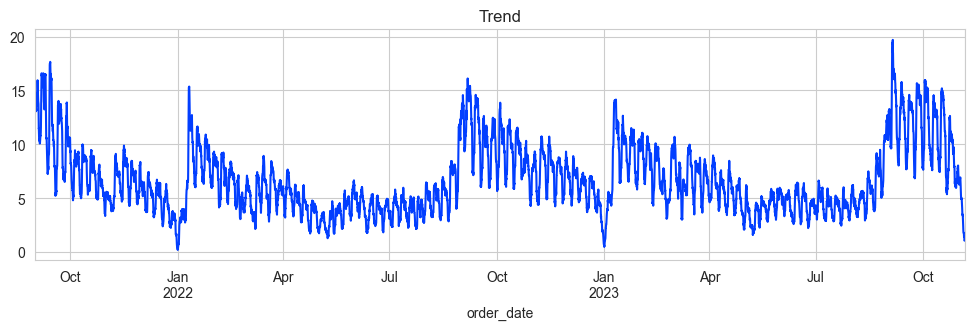

In [568]:
resampled = for_time_analys.resample('1H').sum()
resampled = resampled.target
decomposed = seasonal_decompose(resampled)
plt.figure(figsize=(12,3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

- по визуализации заметно, что точки максимума на графике тренда в разные годы относятся к началу учебного и нового года, а минимума к концу года
- проведу тест Дики-Фуллера для проверки стационарности временного ряда, также построю графики автокорреляции

In [569]:
def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.000000


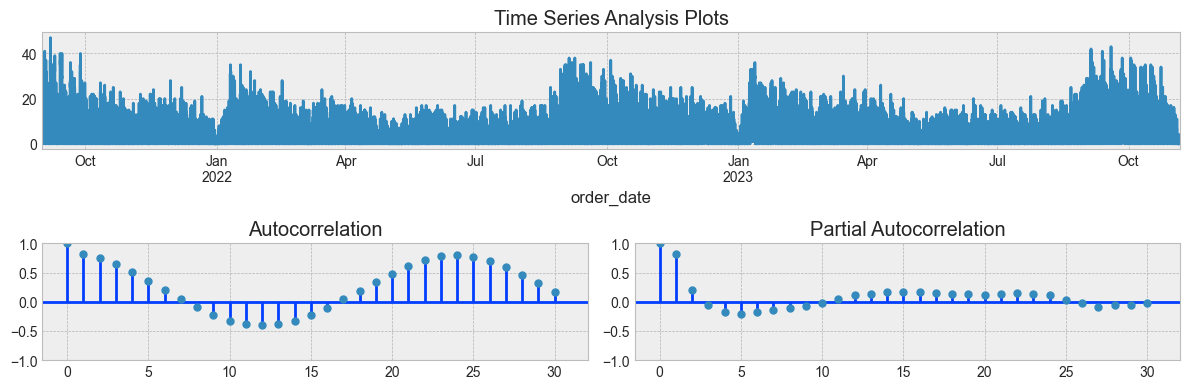

In [570]:
tsplot(resampled, lags=30)

- мы видим(и получаем подтверждение по критерию оценки Дики-Фуллера), что данный временной ряд относится к классу ТS (ряды, становящиеся стационарными после вычитания из них детерминированного тренда)
- также графики автокорреляции демонстрируют, что колебания целевой переменной укладываюся в период равный 14 дням.

In [571]:
typical_student = pd.concat([orders[orders.purpose_lessons!='no'].purpose_lessons.mode(),
    orders.pupil_category_new_id.mode(), orders.pupil_knowledgelvl.mode(),
    orders.max_metro_distance.mode(), orders.lesson_price.mode(),
    orders.planned_lesson_number.mode(), orders.lessons_per_week.mode(),
    orders.is_display_to_teachers.mode()])\
    .reset_index().rename(columns={'index': 'feature', 0: 'value'})
typical_student['feature'] = ['purpose', 'age', 'knowledgelvl', 'metro_dis', 'price',
 'lesson_num', 'lesson_week', 'is_display_to_teacher']
typical_student

feature                        value
0                purpose  помощь, школьной, программе
1                    age                         10.0
2           knowledgelvl                            0
3              metro_dis                         30.0
4                  price                         1000
5             lesson_num                           10
6            lesson_week                            3
7  is_display_to_teacher                            1

In [572]:
pref_teacher = pd.concat([orders.subject_id.mode(), orders.teacher_sex.mode(),
    orders[orders.teacher_experience_from!=0].teacher_experience_from.mode(),
    orders[orders.teacher_age_from!=0].teacher_age_from.mode(),
    orders[orders.teacher_age_to!=0].teacher_age_to.mode(),
    orders.chosen_teachers_only.mode()])\
    .reset_index().rename(columns={'index': 'feature', 0: 'value'})
pref_teacher.feature = ['subject', 'sex', 'experience', 'age_from', 'age_to', 'is_chosen']
pref_teacher

feature  value
0     subject    8.0
1         sex    0.0
2  experience    5.0
3    age_from   25.0
4      age_to   50.0
5   is_chosen    0.0

- Портрет типичного ученика: 
  - 10 лет
  - с начальным уровнем знаний
  - цель занятий: помощь в школьной программе
  - изначально готов на 10 занятий 3 раза в неделю по цене в 1000 руб
  - готов ехать до репетитора в течение 30 минут
  - готов получать отклики репетиторов
- Портрет наиболее востребованного преподавателя:
  - учитель математики
  - пол не важен
  - опыт от 5 лет
  - возраст 25 - 50 лет
  - без конкретизации личности

- так как данные после объединения таблиц будут группироваться по колонке original_order_id, если в ней пропущенное значение значит заявка без дубля и сама является оригиналом,  сначала все эти пропуски заполню данными из столбца id заявки
- так как заказчик поставил задачу разметить дубли по порядку их появления:
  - отсортирую таблицу по возрастанию даты оформления заявки
  - создам столбец ***num_double***, который будет содержать порядковые номера дублей, в соответствии со временем их появления. Установлю пороговое значение для количества дублей, равное 5
  - при наличии хотя бы одного положительного значения в столбце таргет каждой из групп присвою всей группе значение 1
  - так же создам новый столбец ***client_num_orders***, характеризующий количество заявок от одного клиента (столбец с айди клиента было принято решение удалить, как потенциально дающий вероятность утечки данных)

In [573]:
orders.original_order_id.isna().sum()

541456

In [574]:
#предобработка
orders['original_order_id'] = np.where(orders.original_order_id.isna(), orders.id,\
     orders.original_order_id)
orders.original_order_id = orders.original_order_id.astype('int32').astype(str)
orders = orders.sort_values(by='order_date')
group = orders.groupby('original_order_id', as_index=False)
group.ngroups

602992

In [575]:
#предобработка
num_double = []
for k, v in group:
    for n in range(1, len(v)+1):
        num_double.append(n)
orders['num_double'] = num_double
orders['target'] = group.target.transform(lambda x: 1 if x.sum()>0 else 0)
orders = orders[orders.num_double<=5]
orders.target.value_counts().to_frame()

count
target        
0       811111
1       301110

In [576]:
#предобработка
orders.sort_index(inplace=True)
orders.drop('id', axis=1, inplace=True)
orders = orders.rename(columns={'original_order_id': 'order_id'})

In [577]:
#предобработка
client_group = orders.groupby('client_id')
client_group.ngroups

470481

In [578]:
#предобработка
num_double = []
for k, v in client_group:
    for n in range(1, len(v)+1):
        num_double.append(n)
orders['client_num_orders'] = num_double
orders = orders[orders.client_num_orders<=10]
orders.drop('client_id', axis=1, inplace=True)

- столбцы amount_to_pay, estimated_fee, first_lesson_date, payment_date несут в себе информацию из прошлого поэтому должны быть удалены

In [579]:
#предобработка
orders.drop(['amount_to_pay', 'estimated_fee', 'first_lesson_date', 'payment_date'], axis=1, inplace=True)

In [580]:
orders.shape

(1059006, 28)

***Датасет "Репетиторы":***

- разбирать его буду в том же порядке, что и предыдущий:
  - разведовочный анализ/предобработка:
    - временных признаков
    - численных признаков
    - категориальных признаков
  - общий анализ данных по датасету

In [581]:
num_teach = []
cat_teach = []
time_teach = []
for x in teachers.columns:
    if teachers[x].dtype in ['category', 'object']:
        cat_teach.append(x)
    if teachers[x].dtype == 'datetime64[ns]':
        time_teach.append(x)
    if teachers[x].dtype in ['int8', 'int16', 'int32', 'float16']:
        num_teach.append(x)
print("Численный тип данных:", len(num_teach), "cтроковый тип данных:", len(cat_teach),
 'временной тип данных:', len(time_teach))

Численный тип данных: 58 cтроковый тип данных: 16 временной тип данных: 6


- Анализ временных признаков:

  - сначала удалю столбцы status_relevant_date и free_time_relevance_date, так как они состоят практически из одних пропусков (более 80 проц)

In [582]:
#предобработка
teachers.drop(['status_relevant_date', 'free_time_relevance_date'], axis=1, inplace=True)

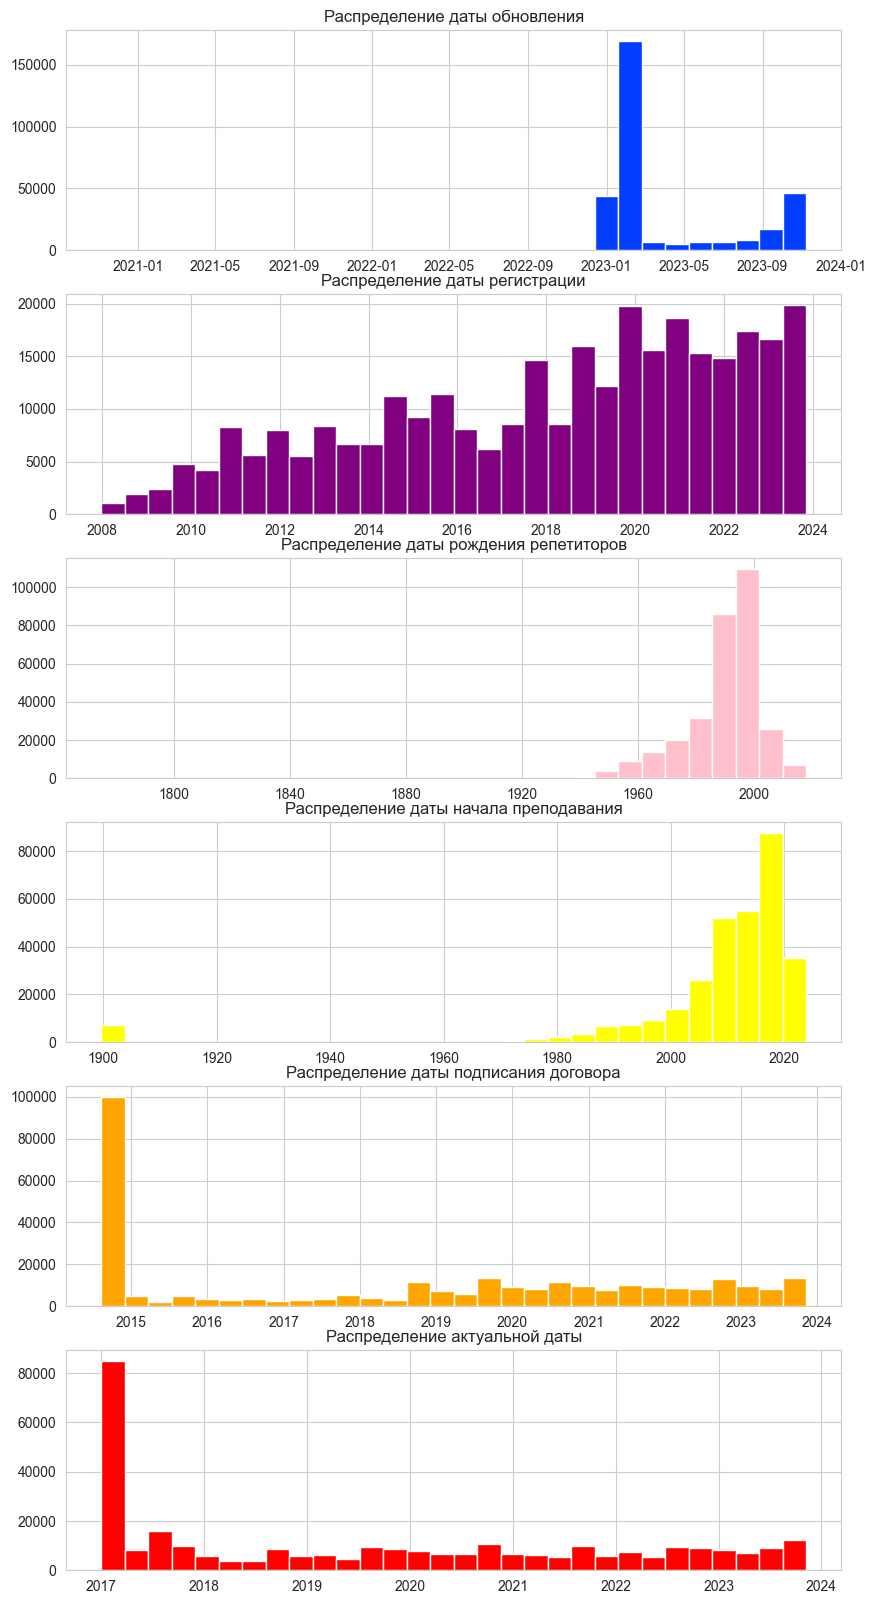

In [583]:
plt.figure(figsize=(10, 20))
plt.subplot(611)
teachers.date_update.sort_values().hist(bins=30)
plt.title('Распределение даты обновления')
plt.subplot(612)
teachers.reg_date.sort_values().hist(bins=30, color='purple')
plt.title('Распределение даты регистрации')
plt.subplot(613)
teachers.birth_date.sort_values().hist(bins=30, color='pink')
plt.title('Распределение даты рождения репетиторов')
plt.subplot(614)
teachers.teaching_start_date.sort_values().hist(bins=30, color='yellow')
plt.title('Распределение даты начала преподавания')
plt.subplot(615)
teachers.rules_confirmed_date.sort_values().hist(bins=30, color='orange')
plt.title('Распределение даты подписания договора')
plt.subplot(616)
teachers.relevance_date.sort_values().hist(bins=30, color='red')
plt.title('Распределение актуальной даты')
plt.show()

- выводы по визуализации:
  - столбец с датой обновления содержит в основном даты конца 2022 начала 2023 года, конечно есть совсем небольшое количество данных за прошлые годы, но никакой полезной информации он не несет, поэтому я его удалю
  - столбец с датой регистрации преподов в системе показывает планомерный рост с 2008 по 2020 год, потом уровень вышел на некое плато со взлетами и падениями, но к концу 2023 года мы опять видим максимальные показатели
  - столбец с датой рождения репетитора: содержит выбросы, которыя я как и в датасете с заявками я ограничу возрастным интервалом 17-90 лет (или 1933-2006 г.р.)
  - аналогичная ситуация и со столбцом о начале преподавания (поставлю минимальный порог - 1950 год), распределение "невыбросных" значений с конца семидесятых по настоящее время
  - мне немного непонятна ситуация со столбцом rules_confirmed_date, а нем основное количество сосредоточено в 2014 году, но если он расшифровывается как я думаю - дата подписания документов, данные в нем должны нарастать также как и в столбце с датой регистрации на платформе, видимо 2014 год проставлялся одним блоком, но так как ситуация не понятна, да и сам столбец не несет полезной информации тоже удалю его; аналогичная сиуация и со столбцом с актуальной датой, он также буде удален.


In [584]:
#предобработка
teachers.birth_date = teachers.birth_date.dt.year
teachers.loc[(teachers.birth_date<1933)|(teachers.birth_date>2006), 'birth_date'] =\
     teachers.birth_date.median()
teachers.teaching_start_date = teachers.teaching_start_date.dt.year
teachers.loc[teachers.teaching_start_date<1950, 'teaching_start_date'] =\
     teachers.teaching_start_date.median()
teachers.drop(['date_update', 'rules_confirmed_date', 'relevance_date'], axis=1, inplace=True)

- Предварительный анализ численных признаков:

  - сразу удалю столбцы status_school_id, status_college_id, status_school_id.1, status_college_id.1, status_school_id.2, status_college_id.2, is_pupils_needed, passport_id, is_individual, status_institution_id состоящие практически из одних пропусков.

In [585]:
#предобработка
teachers.drop(['status_school_id', 'status_college_id', 'status_school_id.1', 'status_college_id.1',
 'status_school_id.2', 'status_college_id.2', 'is_pupils_needed', 'passport_id', 'is_individual',
 'status_institution_id'], axis=1, inplace=True)

In [586]:
teachers[(teachers.is_confirmed==teachers['is_confirmed.1'])\
    &(teachers.is_confirmed==teachers['is_confirmed.2'])]\
    .shape[0]/teachers.shape[0]

1.0

In [587]:
teachers[(teachers.status_id==teachers['status_id.1'])&(teachers.status_id==teachers['status_id.2'])]\
    .shape[0]/teachers.shape[0]

1.0

In [588]:
teachers[(teachers.lesson_duration==teachers['lesson_duration.1'])\
    &(teachers.lesson_duration==teachers['lesson_duration.2'])]\
    .shape[0]/teachers.shape[0]

1.0

In [589]:
teachers[(teachers.lesson_cost==teachers['lesson_cost.1'])\
    &(teachers.lesson_cost==teachers['lesson_cost.2'])]\
    .shape[0]/teachers.shape[0]

1.0

In [590]:
teachers[(teachers.status_display==teachers['status_display.1'])\
    &(teachers.status_display==teachers['status_display.2'])]\
    .shape[0]/teachers.shape[0]

1.0

In [591]:
teachers[(teachers.russian_level_id==teachers['russian_level_id.1'])\
    &(teachers.russian_level_id==teachers['russian_level_id.2'])]\
    .shape[0]/teachers.shape[0]

1.0

In [592]:
teachers[(teachers.home_country_id==teachers['home_country_id.1'])\
    &(teachers.home_country_id==teachers['home_country_id.2'])]\
    .shape[0]/teachers.shape[0]

1.0

Удалю столбцы: is_confirmed.1, is_confirmed.2, status_id.1, status_id.2, lesson_duration.1, lesson_duration.2, lesson_cost.1, lesson_cost.2, status_display.1, status_display.2, russian_level_id.1, russian_level_id.2, home_country_id.1, home_country_id.2, так как они являются полными дубликатами основных столбцов.

In [593]:
#предобработка
teachers.drop(['is_confirmed.1', 'is_confirmed.2', 'status_id.1', 'status_id.2', 'lesson_duration.1',
 'lesson_duration.2', 'lesson_cost.1', 'lesson_cost.2', 'status_display.1', 'status_display.2',
  'russian_level_id.1', 'russian_level_id.2', 'home_country_id.1', 'home_country_id.2'], axis=1,
   inplace=True)

In [594]:
teachers.is_email_confirmed.value_counts().to_frame()

count
is_email_confirmed        
0                   304051
1                     3921

In [595]:
teachers.is_home_lessons.value_counts().to_frame()

count
is_home_lessons        
0                178085
1                129887

In [596]:
teachers.is_external_lessons.value_counts().to_frame()

count
is_external_lessons        
1                    184520
0                    123452

In [597]:
teachers.is_confirmed.value_counts().to_frame()

count
is_confirmed        
1             274189
0              33783

In [598]:
teachers.is_display.value_counts().to_frame()

count
is_display        
1           202872
0           105100

In [599]:
teachers.status_display.value_counts().to_frame()

count
status_display        
1               167455
0               140517

In [600]:
teachers.is_cell_phone_confirmed.value_counts().to_frame()

count
is_cell_phone_confirmed        
0                        305844
1                          2128

In [601]:
teachers.is_remote_lessons.value_counts().to_frame()

count
is_remote_lessons        
1                  157280
0                  150692

In [602]:
teachers.is_edited.value_counts().to_frame()

count
is_edited        
0          163545
1          144427

In [603]:
teachers.is_display_at_partners.value_counts().to_frame()

count
is_display_at_partners        
1                       259182
0                        48790

In [604]:
teachers.show_on_map.value_counts().to_frame()

count
show_on_map        
1            226056
0             81916

In [605]:
teachers.send_mailing.value_counts().to_frame()

count
send_mailing        
1             245209
0              62763

In [606]:
teachers.send_suitable_orders.value_counts().to_frame()

count
send_suitable_orders        
1                     269359
0                      38613

In [607]:
teachers.orders_allowed.value_counts().to_frame()

count
orders_allowed        
1               265072
0                42900

- выводы по бинарным столбцам:
  - is_email_confirmed и is_cell_phone_confirmed самое неравномерное распределение классов с большим перевесом в пользу отрицательного, возможно ***позже*** я их удалю
  - смещенное распределение в сторону положительного класса только у столбцов с данными: показан ли учитель в каталоге и подтвержден ли, остальные признаки распределены более менее равномерно

Распределение некоторых численных признаков:


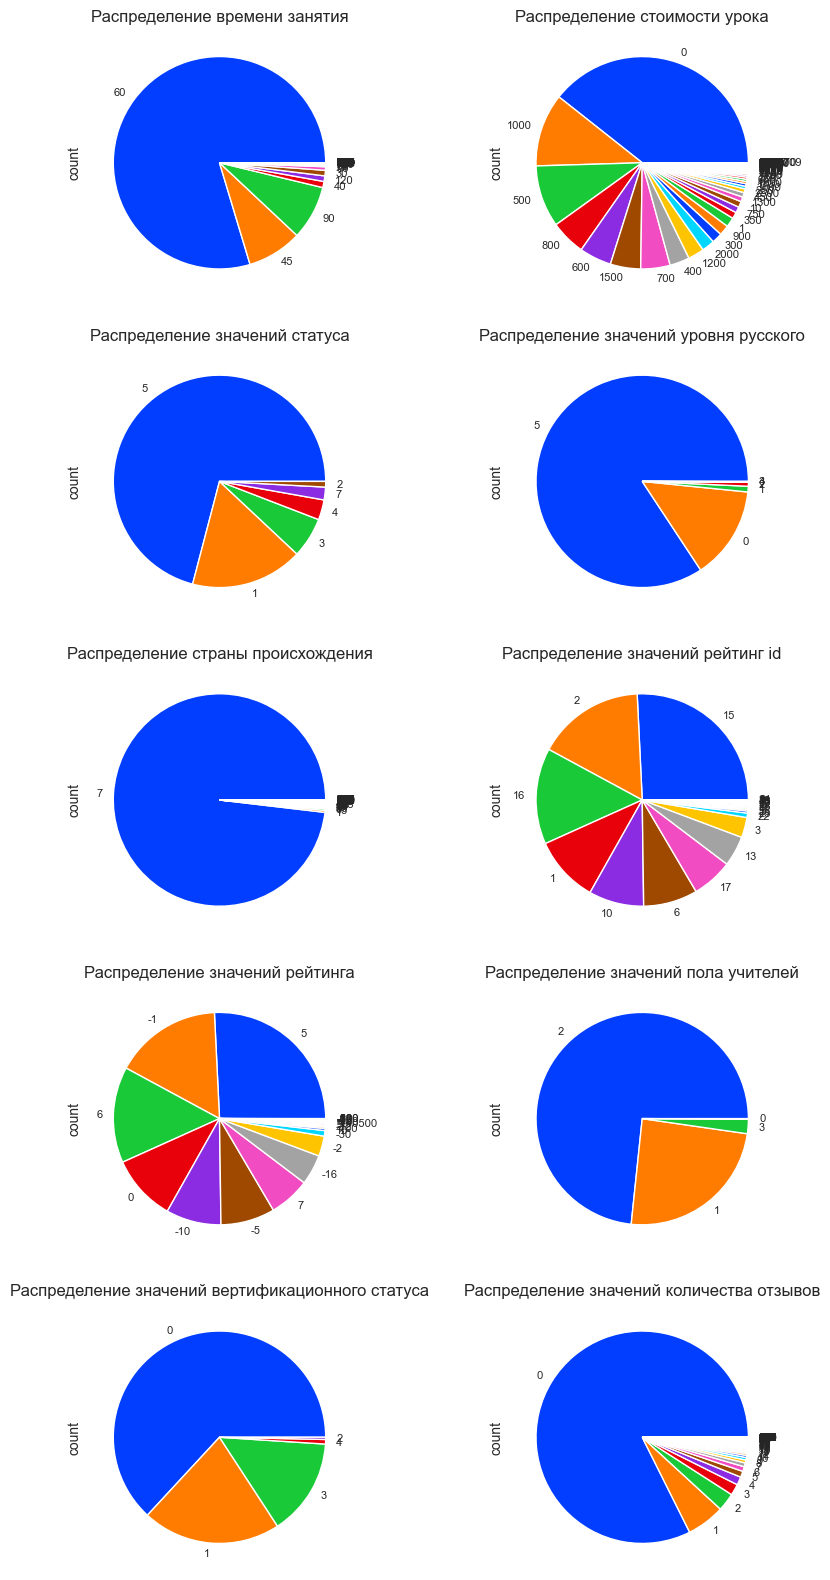

In [608]:
print('Распределение некоторых численных признаков:')
fig, axs = plt.subplots(figsize=(10, 20), nrows=5, ncols=2)
teachers.lesson_duration.value_counts().plot(kind='pie', fontsize=8, ax=axs[0,0])\
    .set_title('Распределение времени занятия')
teachers.lesson_cost.value_counts().plot(kind='pie', fontsize=8, ax=axs[0,1])\
    .set_title('Распределение стоимости урока')
teachers.status_id.value_counts().plot(kind='pie', fontsize=8, ax=axs[1,0])\
    .set_title('Распределение значений статуса')
teachers.russian_level_id.value_counts().plot(kind='pie', fontsize=8, ax=axs[1,1])\
    .set_title('Распределение значений уровня русского')
teachers.home_country_id.value_counts().plot(kind='pie', fontsize=8, ax=axs[2,0])\
    .set_title('Распределение страны происхождения')
teachers.rating_id.value_counts().plot(kind='pie', fontsize=8, ax=axs[2,1])\
    .set_title('Распределение значений рейтинг id')
teachers.rating.value_counts().plot(kind='pie', fontsize=8, ax=axs[3,0])\
    .set_title('Распределение значений рейтинга')
teachers.sex.value_counts().plot(kind='pie', fontsize=8, ax=axs[3,1])\
    .set_title('Распределение значений пола учителей')
teachers.verification_status_id.value_counts().plot(kind='pie', fontsize=8, ax=axs[4,0])\
    .set_title('Распределение значений вертификационного статуса')
teachers.review_num.value_counts().plot(kind='pie', fontsize=8, ax=axs[4,1])\
    .set_title('Распределение значений количества отзывов')
plt.show()

- выводы по визуализации:
  - столбец распределение времени занятия - превалирует 60 мин
  - столбец распределение стоимости урока - большее количество данных не проставлено, затем следует 1000, 500
  - столбец распределение значений статуса - превалирует значение 5
  - столбец распределение значений уровня русского - большее количество имеет макс уровень, следующее значение: уровень не проставлен
  - столбец распределение значений страны происхождения - подавляющее количество у значения 7 (видимо РФ), удалю столбец так как это значение подавляет все остальные
  - столбец распределение значений рейтинг id - лидирует значение 15
  - столбец распределение значений рейтинга - лидирует значение 5
  - столбец распределение пола учителей - превалирует женский (2), затем мужской (1), значения 0 и 3 объединю в одно 0 - пол не проставлен
  - столбец распределение значений верификационного статуса - лидирует значение 0
  - столбец распределение отзывов - лидирует 0 значение (отсутствие таковых)

In [609]:
#предобработка
teachers.sex = [1 if x==1 else 2 if x==2 else 0 for x in teachers.sex]
teachers.drop('home_country_id', axis=1, inplace=True)
teachers.loc[teachers.lesson_cost==0, 'lesson_cost'] = teachers.lesson_cost.median()

In [610]:
teachers[teachers.rating_for_users==teachers.rating_for_users_yesterday].id.count()/teachers.shape[0]

0.9804202979491642

- так как столбец прошлый рейтинг для пользователей отличается от столбца рейтинг для пользователей только на 2% - удалю его

In [611]:
#предобработка
teachers.drop('rating_for_users_yesterday', axis=1, inplace=True)

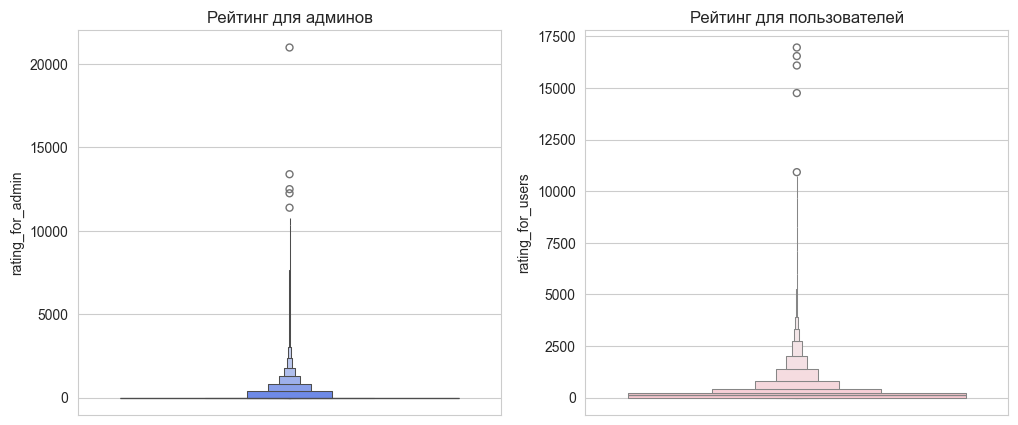

In [612]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2)
sns.boxenplot(teachers.rating_for_admin, ax=axs[0]).set_title('Рейтинг для админов')
sns.boxenplot(teachers.rating_for_users, color='pink', ax=axs[1]).set_title('Рейтинг для пользователей')
plt.show()

- ненормальное распределение с выбросами для обоих столбцов (рейтинг для админов и для пользователей), в значениях присутствуют как однозначные так и четырехзначные значения, так как убрать в этих случаях выбросы не представляется возможным - удалю эти столбы

In [613]:
#предобработка
teachers.drop(['rating_for_users', 'rating_for_admin'], axis=1, inplace=True)

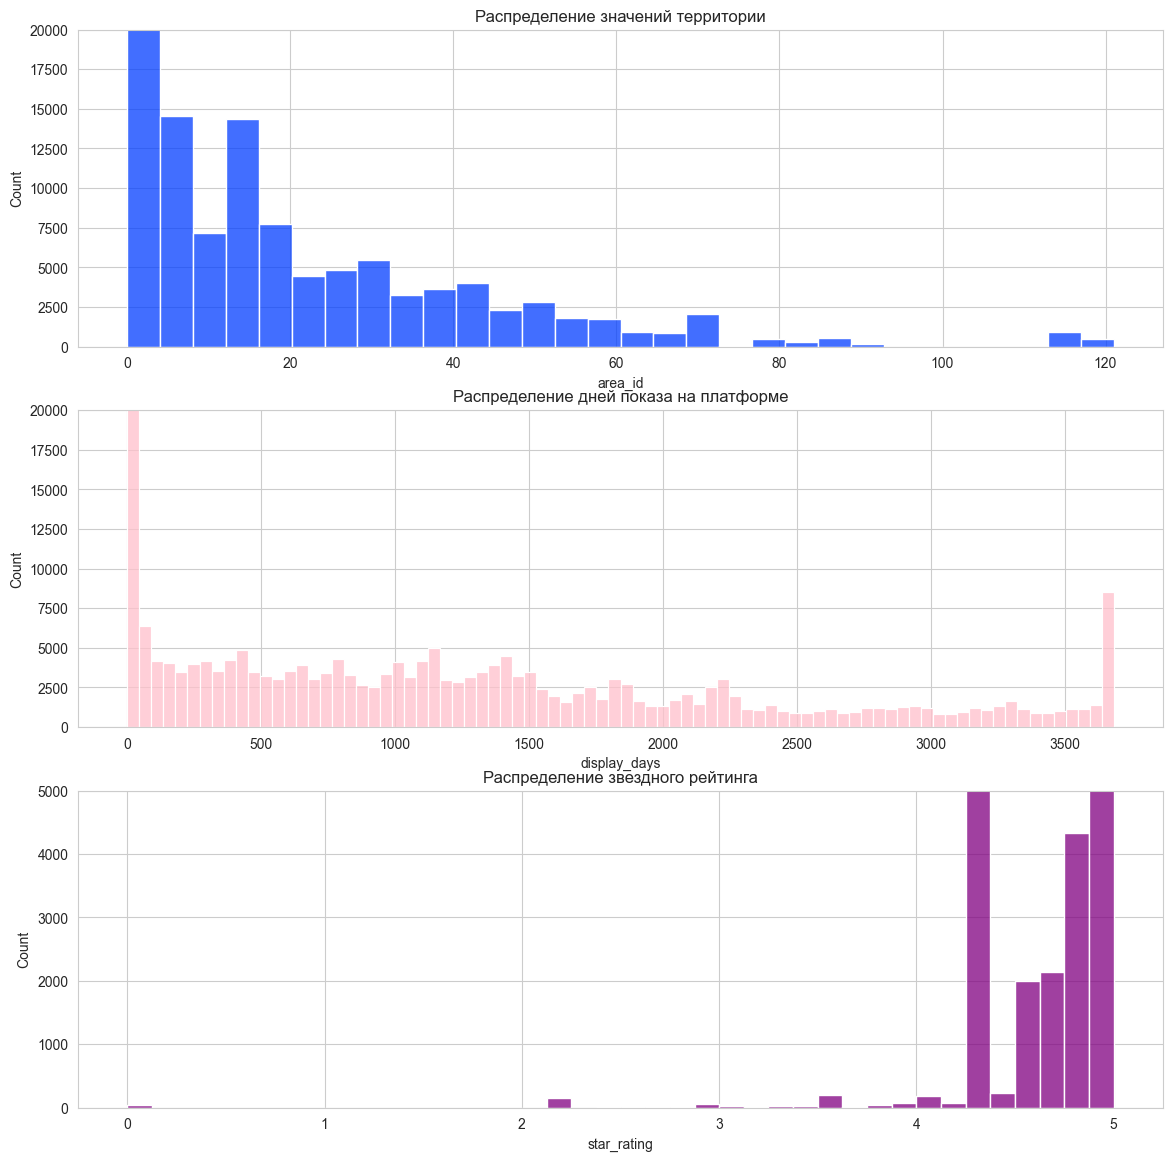

In [614]:
plt.figure(figsize = (14, 14))
plt.subplot(311)
sns.histplot(teachers.area_id, bins=30)
plt.title('Распределение значений территории')
plt.ylim(0, 20000)
plt.subplot(312)
sns.histplot(teachers.display_days, color='pink')
plt.title('Распределение дней показа на платформе')
plt.ylim(0, 20000)
plt.subplot(313)
sns.histplot(teachers.star_rating, bins=40, color='purple')
plt.title('Распределение звездного рейтинга')
plt.ylim(0, 5000)
plt.show()

In [615]:
teachers.amount_to_pay.value_counts().to_frame()

count
amount_to_pay        
0              307757
500               213
1                   2

- распределение значений по территории неравномерно - ,большинство значений относится к значению 1
- распределение дней показа на платформе - большинство позиций занимает значение 0 (не показаны на платформе), что в принципе "бъется" со значениями бинарного столбца о показах, соотвественно это корелирующие между собой значения и я удалю бинарный столбец is_display
- распределение столбца сумма к выплате имеет три частоты распределения, одна из которых (0) занимает подавляющее значение, поэтому данный столбец не несет никакой дополнительной информации и я удалю его

In [616]:
#предобработка
teachers.drop(['is_display', 'amount_to_pay'], axis=1, inplace=True)

Предварительный анализ категориальных признаков:

- столбцы external_comments, external_comments.1, external_comments.2 - аналогичны ( содержащие в основном информацию о конкретных адресах) имеют 71% пропусков и будут удалены за неинформативность; 
- столбцы information, information.1, information.2 - аналогичны, имеют 51% пропусков, но так как они несут информацию о прщцессе обучения я пока удалю только последние два из них и попробую поработать с первым;
- столбцы status_relevant_date.1, status_relevant_date.2 - аналогичны, имеют 85% пропусков и будут удалены
- столбец с комментариями операторов comments имеет 85% пропусков и будет удален
- столбец pupil_needed_date имеет 90% пропусков и будет удален, аналогичная ситуация и со столбцами: remote_comments, partner_id 
- столбец photo_path: пропуски и значения без фото будут заменены 0, присутствие фото - обозначено 1
- last_visited (с информацией о последнем визите преподавателя на платформу) - пока оставлю без изменений, возможно этот столбец понадобится позже для генерации временных признаков.

In [617]:
#предобработка
teachers.photo_path = np.where((teachers.photo_path=='/photo/no_photo.png')|(teachers.photo_path.isna()),\
     0, 1)

In [618]:
FreqDist(Text(teachers.information)).most_common(10)

[(nan, 175000),
 ('РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА', 6916),
 ('[p]РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА[/p]', 192),
 ('Действующий школьный преподаватель.', 154),
 ('Опыт работы в школе.', 152),
 ('\n', 115),
 ('[p]&nbsp;[/p][p]&nbsp;[/p]', 105),
 ('[p]Опыт работы в школе.[/p]', 95),
 (' ', 87),
 ('Ранее школьный преподаватель.', 81)]

- столбец "информация" в этом датасете, кроме подавляющего количества пропусков содержит незначительное количество служебной информации, поэтому я приняла решение его удалить

In [619]:
#предобработка
teachers.drop(['external_comments', 'external_comments.1', 'external_comments.2', 'information.1',
 'information.2', 'status_relevant_date.1', 'status_relevant_date.2', 'pupil_needed_date', 'remote_comments',
  'partner_id', 'comments', 'information'], axis=1, inplace=True)

In [620]:
teachers.shape

(307972, 33)

Анализ столбца с информацией о репетиторах:

  - составлю портрет типичного репетитора на данной платформе

In [621]:
typical_teacher =  pd.concat([teachers.birth_date.mode(),teachers.teaching_start_date.mode(),\
    teachers.is_home_lessons.mode(), teachers.lesson_duration.mode(), teachers.lesson_cost.mode(),\
        teachers.status_id.mode(), teachers.status_display.mode(), teachers.is_confirmed.mode(),\
            teachers.rating_id.mode(), teachers.rating.mode(), teachers.sex.mode(),
            teachers.is_remote_lessons.mode(), teachers.send_suitable_orders.mode(),\
                teachers.star_rating.mode(), teachers.review_num.mode(),\
                     teachers.is_display_at_partners.mode()])\
    .reset_index().rename(columns={'index': 'feature', 0: 'value'})
typical_teacher.feature = ['birth_date', 'teaching_start_date', 'is_home_lessons', 'lesson_duration',
 'lesson_cost', 'status_id', 'status_display', 'is_confirmed', 'rating_id', 'rating', 'sex',
  'is_remote_lessons', 'send_suitable_orders', 'star_rating', 'review_num', 'is_display_at_partners']
round(typical_teacher)

feature   value
0               birth_date  1992.0
1      teaching_start_date  2012.0
2          is_home_lessons     0.0
3          lesson_duration    60.0
4              lesson_cost   500.0
5                status_id     5.0
6           status_display     1.0
7             is_confirmed     1.0
8                rating_id    15.0
9                   rating     5.0
10                     sex     2.0
11       is_remote_lessons     1.0
12    send_suitable_orders     1.0
13             star_rating     4.0
14              review_num     0.0
15  is_display_at_partners     1.0

- Итак, типичный репетитор на платформе это:
  - женщина
  - возраст 30+
  - преподавательский стаж около 11 лет
  - предпочитающая заниматься онлайн
  - не назначившая стоимость занятия
  - с подтвержденным статусом на платформе
  - статус id = 5, рейтинг id = 15, рейтинг = 5 (значения статуса и рейтингов не известны)
  - ее статус отображен на платформе
  - не готова заниматься на дому (хотела удалить этот столбец, так как думала он коллинеарен с удаленными уроками, но посмотрела, что у них разное распределение поняла, что это разные понятия: первое он и офлайн, второе у себя на дому или нет)
  - отправляющая подходящие заявки
  - со звездным рейтингом около 4
  - без отзывов
  - ее кандидатура размещена также и на других платформах.

***Датасет "Подходящие по фильтру репетиторы:"***

In [622]:
teachers_filtr.isna().sum().to_frame(name='Итого пропусков:')

Итого пропусков:
teacher_id                         0
order_id                           0
contact_result              12824319
enable_auto_assign                 0
enable_assign                      0

In [623]:
teachers_filtr.contact_result.isna().sum()/teachers_filtr.shape[0]

0.6326393531847769

In [624]:
teachers_filtr.contact_result = teachers_filtr.contact_result.astype(str)
teachers_filtr[teachers_filtr.contact_result!='nan'].contact_result.unique()

array(['Репетитор согласился',
       'Репетитор положил трубку, либо обрыв связи (Oktell)', ',', ...,
       'Репетитор согласился с дополнительными условиями(занятия в паре и не в восркресенье, нужно искть окно. Занятие длится 120 минут стоимость 1300)',
       'Репетитор согласился с дополнительными условиями(после 17 часов)',
       'к ученику?'], dtype=object)

- столбец с результатами контактов операторов с репетиторами содержит в основном уточняющую переписку, информация из которой разрознена, также в этом столбце 63% пропусков, удалю его за неинформативность

In [625]:
#предобработка
teachers_filtr.drop('contact_result', axis=1, inplace=True)

In [626]:
teachers_filtr.enable_assign.value_counts().to_frame()

count
enable_assign          
0              19712703
1                558434

In [627]:
teachers_filtr.enable_auto_assign.value_counts().to_frame()

count
enable_auto_assign          
0                   17653964
1                    2617173

In [628]:
#предобработка
teachers_filtr[['order_id']] = teachers_filtr[['order_id']].astype(str)

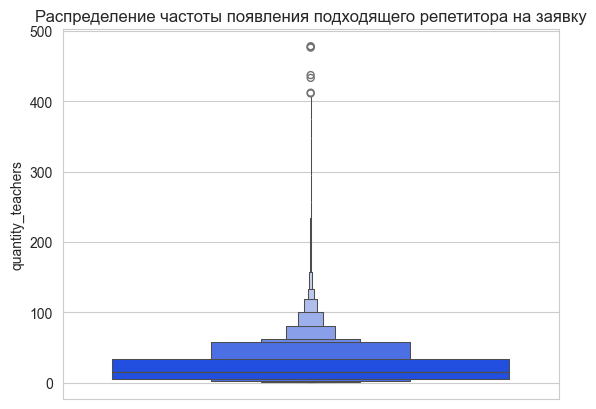

In [629]:
groupd_orders = teachers_filtr.groupby('order_id')['teacher_id'].count()\
    .to_frame(name='quantity_teachers').reset_index()
sns.boxenplot(groupd_orders.quantity_teachers)
plt.title('Распределение частоты появления подходящего репетитора на заявку')
plt.show()

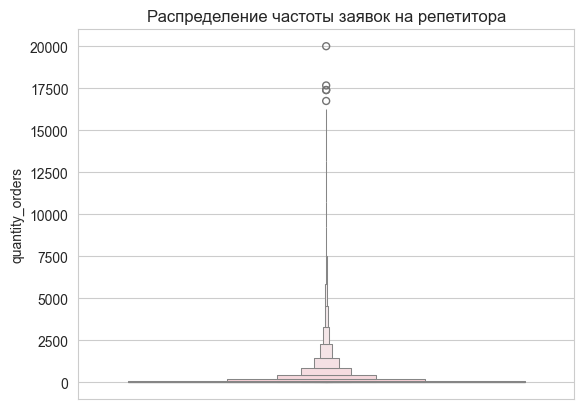

In [630]:
groupd_teachers = teachers_filtr.groupby('teacher_id')['order_id'].count()\
    .to_frame(name='quantity_orders').reset_index()
sns.boxenplot(groupd_teachers.quantity_orders, color='pink')
plt.title('Распределение частоты заявок на репетитора')
plt.show()

- итак видно, что на большинство заявок подходит небольшое количество преподавателей, хотя есть и заявки на которые подходят около 500 кандидатур), аналогичная ситуация и с распределением количества заявок на репетитора.

In [631]:
groupd_orders.shape

(842019, 2)

In [632]:
groupd_teachers.shape

(145944, 2)

***Объединение таблиц:***

- для этого сначала объединю таблицы "Информация по репетиторам" и "Подходящие по фильтру репетиторы" по общему столбцу teacher_id
- затем сгруппирую получившуюся таблицу по столбцу order_id, причем сагрегирую столбцы следующим образом:
  - временные, рейтинговые признаки через медианные значения
  - бинарные признаки через первое
  - столбец user_id, в котором собраны идентификаторы как учителей, так и клиентов, и операторов, и сотрудников, я пока не буду вносить в агрегацию
  - столбец enable_assign также уберу из агрегации, так как столбец enable_auto_assign является его дополненной версией
- затем объединю получившийся столбец со столбцом с информацией по заявкам

In [633]:
#предобработка
teachers = teachers.rename(columns={'id': 'teacher_id'})
merged_teachers = teachers_filtr.merge(teachers, on='teacher_id')

In [634]:
#предобработка
grouped_teachers_info = merged_teachers.groupby('order_id', as_index=False)\
    .agg(reg_date = ('reg_date', 'median'),
    status_id = ('status_id', 'median'),
    is_email_confirmed = ('is_email_confirmed', 'first'),
    is_home_lessons = ('is_home_lessons','first'),
    is_external_lessons = ('is_external_lessons', 'first'),
    status_display = ('status_display','first'),
    russian_level_id = ('russian_level_id', 'median'), is_confirmed = ('is_confirmed', 'first'),
    rating_id = ('rating_id', 'median'), rating = ('rating', 'median'),
    is_cell_phone_confirmed = ('is_cell_phone_confirmed', 'first'), area_id = ('area_id', 'median'),
    effective_rating = ('effective_rating', 'median'),
    is_remote_lessons = ('is_remote_lessons', 'first'),
    show_on_map = ('show_on_map', 'first'), send_mailing = ('send_mailing', 'first'),
    send_suitable_orders = ('send_suitable_orders', 'first'),
    is_edited = ('is_edited', 'first'), review_num = ('review_num', 'sum'),
    orders_allowed = ('orders_allowed', 'first'), star_rating = ('star_rating', 'median'),
    verification_status_id = ('verification_status_id', 'median'), 
    is_display_at_partners = ('is_display_at_partners', 'first'),
    enable_auto_assign = ('enable_auto_assign', 'first'),
    display_days = ('display_days', 'mean'),
    teacher_id_count = ('teacher_id', 'count'), birth_date = ('birth_date', 'median'),
    teaching_start_date = ('teaching_start_date', 'first'), lesson_duration = ('lesson_duration', 'first'),
    lesson_cost = ('lesson_cost', 'first'), photo_path = ('photo_path', 'first'),
    sex = ('sex', 'mean'))

- проведу обработку столбца со сгруппированными данными - пол учителя(если среднее значение больше 1.5 - поставлю значение 2, т.е преимущественен женский пол, и наоборот соотвественно):

In [635]:
#предобработка
grouped_teachers_info.sex = pd.Series(np.where(grouped_teachers_info.sex>=1.5, 2, 1)).value_counts()
grouped_teachers_info.reg_date = grouped_teachers_info.reg_date.dt.round('H')
grouped_teachers_info.birth_date = grouped_teachers_info.birth_date.astype(int)
df = orders.merge(grouped_teachers_info, on='order_id')
df = df.fillna(0.0)
df = df.rename(columns={'lesson_duration_x': 'lesson_duration_for_client', 'lesson_duration_y':\
    'lesson_duration_for_teacher'})
df.shape

(866571, 60)

***3. Отбор и подготовка признаков для работы с моделями***

- сначала посмотрю на корелляцию признаков между собой в объединенном датасете, уберу признаки, которые дают мультиколлинеарность, при их наличии
- также необходимо "очистить" датасет от признаков "из будущего", чтобы не было дата-ликов
- создам новые признаки
- переведу категориальные признаки в строковый тип
- разделю датасет на тренировочную, валидационную и тестовую часть (обязательно проверив сначала, чтобы датасет был отсортирован по времени-по дате возрастания номера заявки в нашем случае), сделав это так, чтобы группы дублей не разделялись и не попадали в разные части
- попробую разные методы векторизации текстов (при помощи словаря индексов, модели Word2Vec(или Fasttext), обученной языковой модели), сравню полученые метрики от базлайн модели и выберу лучшего метода векторизации
- попробую провести обучение данных с имеющимися выбросами, оценю результат
- проведеду "очистку" датасета от выбросов, также проверю метрики на базлайн модели, сравненю результаты и выберу финальный вариант датасета для обучения

- сделаю тепловую карту на все признаки, а потом на две самые связанные ее части поближе:

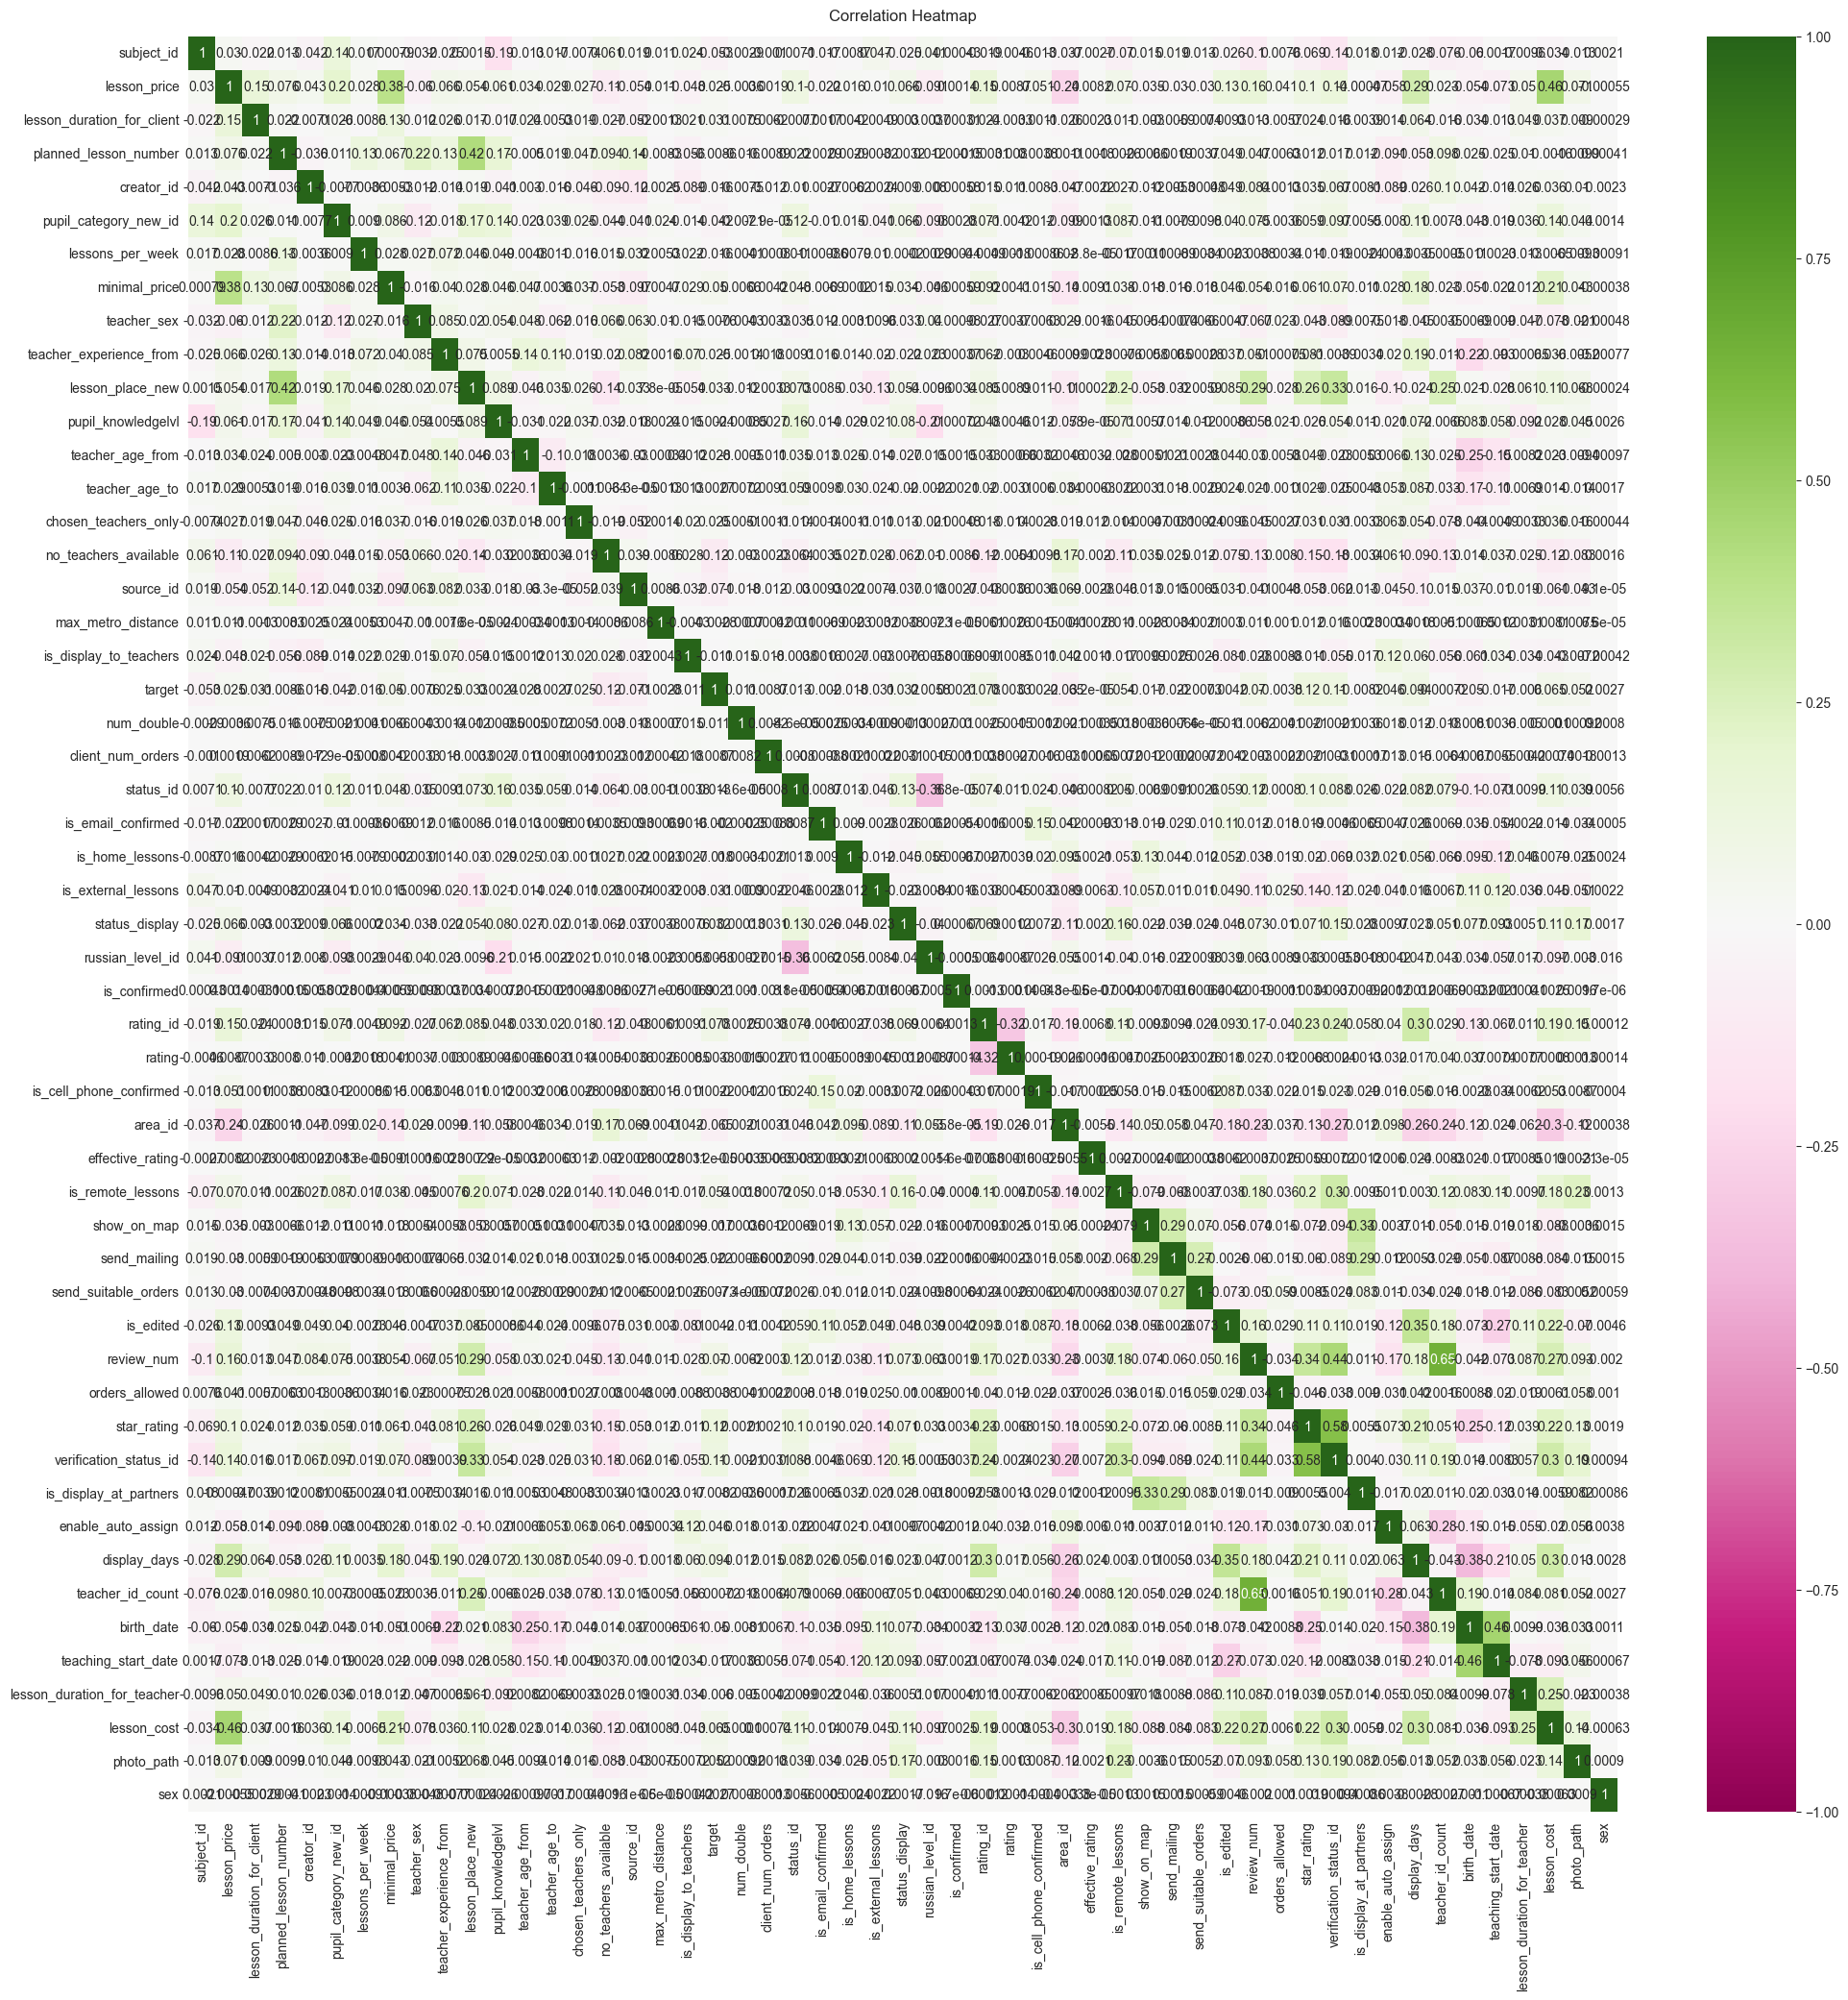

In [636]:
plt.figure(figsize=(24, 24))
heatmap = sns.heatmap(df.drop(['order_date', 'reg_date', 'purpose_sections', 'purpose_categories',
 'purpose_lessons', 'purpose', 'order_id'], 
  axis=1).corr(), vmin=-1, vmax=1, cmap='PiYG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

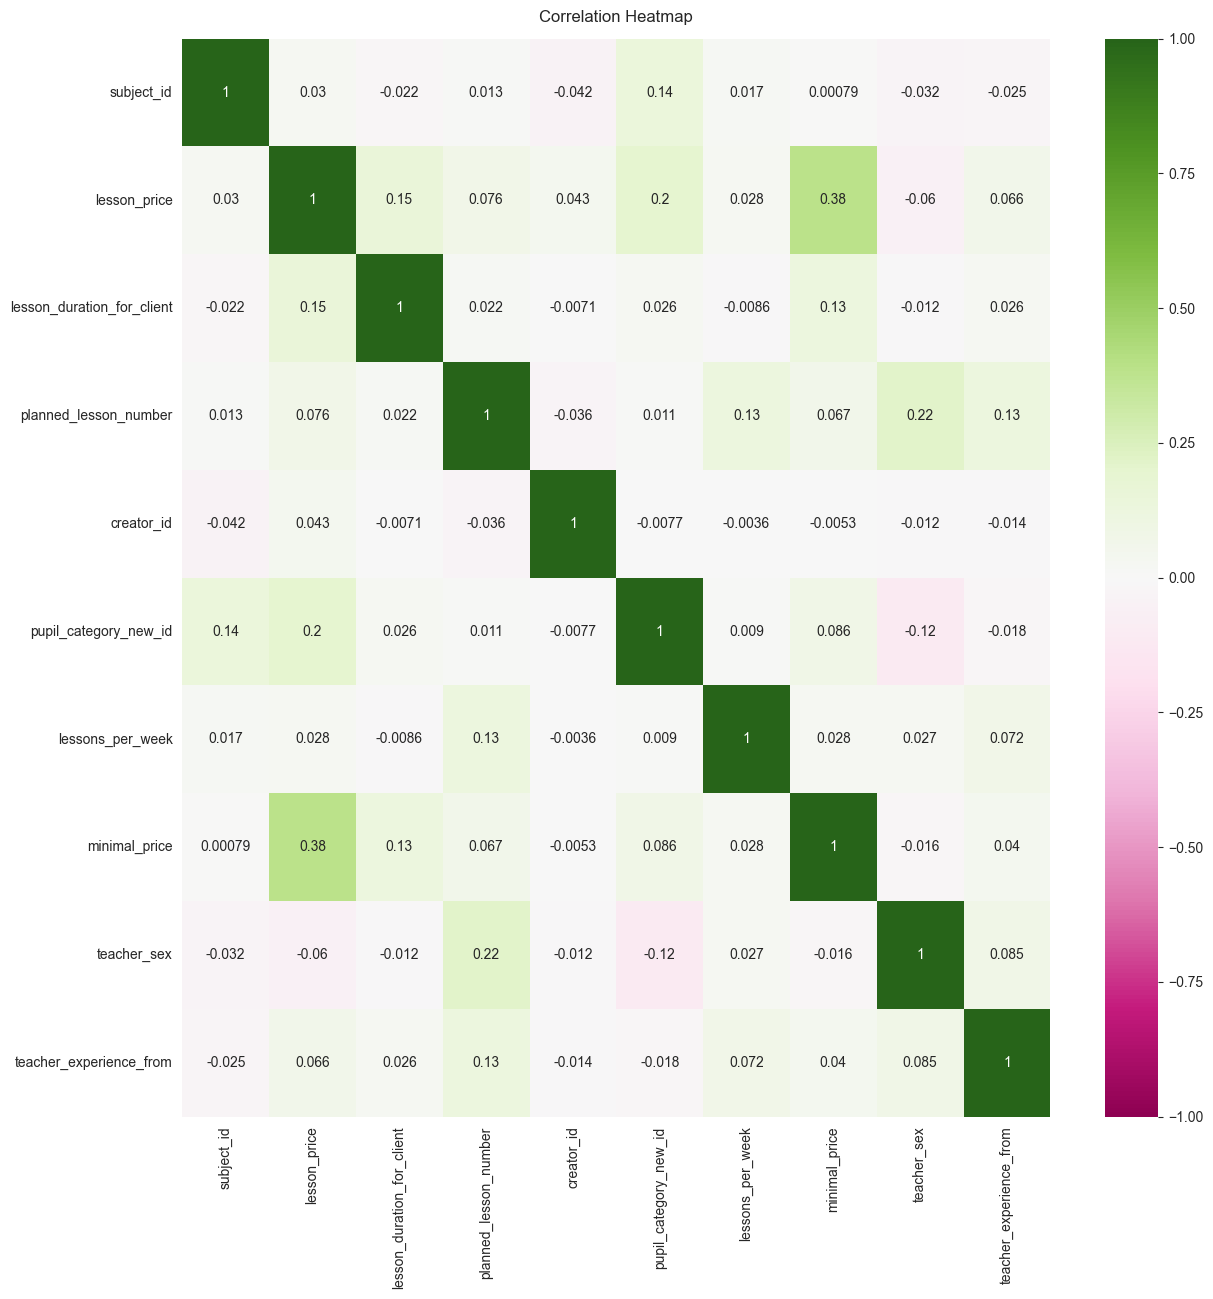

In [637]:
plt.figure(figsize=(14, 14))
heatmap = sns.heatmap(df[['subject_id', 'lesson_price', 'lesson_duration_for_client', 'planned_lesson_number',
 'creator_id', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex',
 'teacher_experience_from']].corr(), vmin=-1, vmax=1, cmap='PiYG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

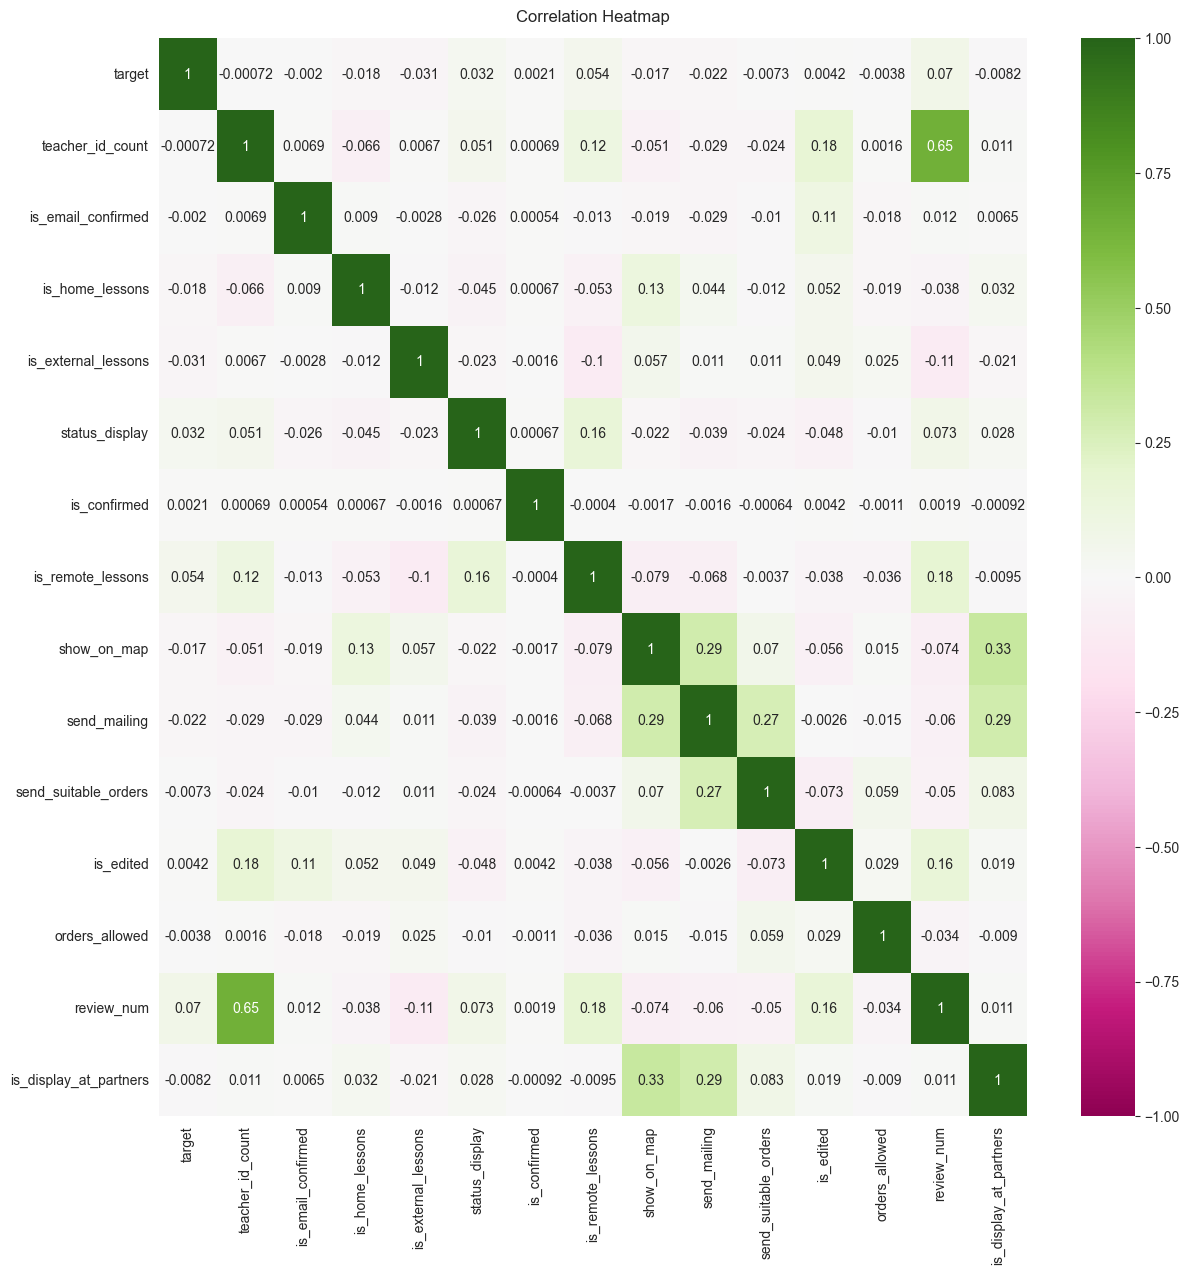

In [638]:
plt.figure(figsize=(14, 14))
heatmap = sns.heatmap(df[['target', 'teacher_id_count', 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons',
 'status_display', 'is_confirmed', 'is_remote_lessons', 'show_on_map', 'send_mailing', 'send_suitable_orders',
 'is_edited', 'orders_allowed', 'review_num', 'is_display_at_partners']].corr(), vmin=-1, vmax=1, cmap='PiYG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

- видим, что предполагаемая стоимость урока достаточно хорошо связана с планируемым общим количеством занятий и количеством занятий в неделю(которые между собой показывают самый высокий коэффициент - возможно позже удалю один из этих признаков (возможна мультиколинеарность))
- таргет относительно неплохо корелирует с айди клиента, источником заполнения заявки и рейтинговыми признаками
- вторая карта состоит из признаков датасета с данными о репетиторах. Сначала я сагрегировала бинарные признаки из этого датасета через сумму и они дали между собой мультиколинеарность. ***Пока*** с точки зрения колинеарности не буду изменять датасет
- создание новых признаков:
  - я уже создала новые признаки: 
    - порядковый номер дубля (по предложению заказчика)
    - порядковый номер заявки на одного клиента
    - количество учителей, подходящих по фильтру на 1 заявку
    - три столбца из столбца purpose (информация о предметах, категориях учеников и целях занятий)
  - здесь я сначала создам признаки из имеющихся временных отметок

In [639]:
#предобработка
df['order_year'] = df.order_date.dt.year
df['order_month'] = df.order_date.dt.month
df['order_week']= df.order_date.dt.day_of_week
df['order_day'] = df.order_date.dt.day
df['order_hour'] = df.order_date.dt.hour
df['reg_year'] = df.reg_date.dt.year

- чтобы разделить датасет на тренировочную/валидационную/тестовую части и при этом не разделять группы дублей, я создам список с названиями первых строк каждой группы, затем разделю их в нужных пропорциях и соотвественно по ним составлю тренировочную/валидационную и тестовую выбоки:

In [640]:
#предобработка
list_of_firsts = df.groupby('order_id').nth(0).order_id.tolist()
train_first_, test_first = train_test_split(list_of_firsts, random_state=random_state, test_size=0.1)
train_first, val_first = train_test_split(train_first_, random_state=random_state, test_size=0.11)
X_train = df[df.order_id.isin(train_first)].drop('target', axis=1)
y_train = df[df.order_id.isin(train_first)].target
X_val = df[df.order_id.isin(val_first)].drop('target', axis=1)
y_val = df[df.order_id.isin(val_first)].target
X_test = df[df.order_id.isin(test_first)].drop('target', axis=1)
y_test = df[df.order_id.isin(test_first)].target
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(694139, 65) (694139,) (85615, 65) (85615,) (86817, 65) (86817,)


- попробую разные методы векторизации текстов, причем у меня два способа предобработки столбца purpose (обработка при помощи паттернов и разбиение его на три столбца), оценю результаты и выберу лучший метод векторизации и вариант предобработки текста
- сначала отделю текстовые признаки, также разделю их на тренировочную/валидационную/тестовую части и буду пробовать методы векторизации:
  - векторизация, с использованием словаря индексов
  - при помощи countvectorizer(tfidf)
  - модели word2vec

In [641]:
text = df[['purpose_sections', 'purpose_categories', 'purpose_lessons']].agg(', '.join, axis=1)

In [642]:
def vectorize(text):
    splitted_text = [x.split(', ') for x in text]
    words = Counter()
    for sentence in tqdm(splitted_text):
        for word in sentence:
            words[word] += 1
    vocab = set()
    for word, count in words.items():
        if word not in vocab:
            vocab.add(word)
    word2ind = {char: i for i, char in enumerate(vocab)}
    ind2word = {i: char for char, i in word2ind.items()}
    vectorized_text = [[word2ind.get(x) for x in y] for y in splitted_text]
    norm_vectors = [[round((x-np.mean(y))/np.std(y), 2) if len(y)>1 else .0 for x in y] for y in vectorized_text]
    return norm_vectors

In [643]:
vect_categories = vectorize(df.purpose_categories)
vect_lessons = vectorize(df.purpose_lessons)
vect_sections = vectorize(df.purpose_sections)

  0%|          | 0/866571 [00:00<?, ?it/s]

  0%|          | 0/866571 [00:00<?, ?it/s]

  0%|          | 0/866571 [00:00<?, ?it/s]

In [644]:
text_df = pd.concat([pd.DataFrame(vect_categories), pd.DataFrame(vect_lessons), pd.DataFrame(vect_sections)],\
     axis=1).fillna(0)

In [645]:
X_train_text = text_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = text_df.iloc[df[df.order_id.isin(val_first)].index]
X_test_text = text_df.iloc[df[df.order_id.isin(test_first)].index]
print('Размер тренировочной выбоки:', X_train_text.shape, 'размер валидационной выборки:', X_val_text.shape,\
    'размер тестовой выборки:', X_test_text.shape)

Размер тренировочной выбоки: (694139, 229) размер валидационной выборки: (85615, 229) размер тестовой выборки: (86817, 229)


In [646]:
lr = LogisticRegression(random_state=random_state)
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.553522281254259


In [647]:
vect_purpose = vectorize(df.purpose)

  0%|          | 0/866571 [00:00<?, ?it/s]

In [648]:
text_df_all = pd.DataFrame(vect_purpose).fillna(0)

In [649]:
X_train_all_text = text_df_all.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = text_df_all.iloc[df[df.order_id.isin(val_first)].index]
X_test_all_text = text_df_all.iloc[df[df.order_id.isin(test_first)].index]

In [650]:
lr = LogisticRegression(random_state=random_state)
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5297230850191208


- первый вывод - результат лучше у созданных трех столбцов. Чтобы выбрать количество кластеров воспользуюсь методом локтя(подбор занимает достаточно времени поэтому я оставила только первый цикл, но все остальные подбирались также)

In [651]:
'''dis = []
K = range(1, 11)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(text_df.values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');'''

"dis = []\nK = range(1, 11)\nfor k in K:\n    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)\n    m.fit(text_df.values)\n    dis.append(m.inertia_)\nplt.plot(K, dis, 'bx-');"

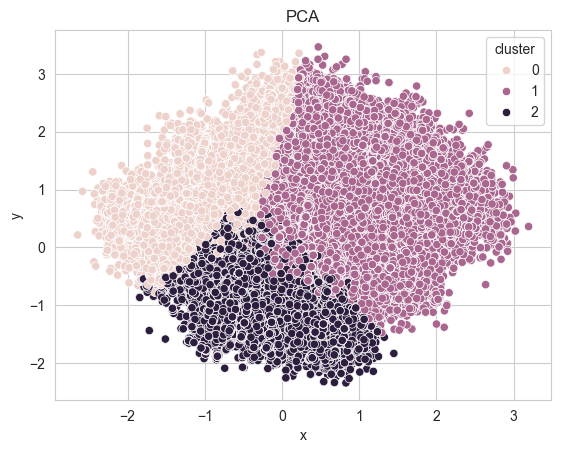

In [652]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(text_df.values)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(text_df.values)
pca3D_df = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df)
plt.title("PCA")
plt.show()

In [653]:
X_train_text = pca3D_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = pca3D_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5562521866856193


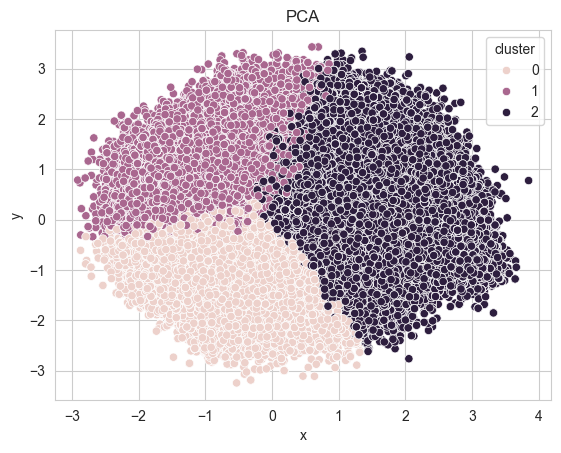

In [654]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(text_df_all.values)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(text_df_all.values)
pca3D_df = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df)
plt.title("PCA")
plt.show()

In [655]:
X_train_all_text = pca3D_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = pca3D_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.513478305724892


- видим, что сжатие размерности сильно не ухудшает метрику в данном случае
- теперь буду создавать вектора при помощи CountVectorizer:

In [656]:
text = df[['purpose_sections', 'purpose_categories', 'purpose_lessons']].agg(', '.join, axis=1)
count_vectorizer = CountVectorizer(ngram_range=(1,6), analyzer='char', max_features=100)
count_vectors_df_ = pd.DataFrame(count_vectorizer.fit_transform(text).toarray())
X_train_text = count_vectors_df_.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = count_vectors_df_.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5701313784077171


In [657]:
count_vectorizer = CountVectorizer(ngram_range=(1,6), analyzer='char', max_features=100)
count_vectors_df = pd.DataFrame(count_vectorizer.fit_transform(df.purpose).toarray())
X_train_all_text = count_vectors_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = count_vectors_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5759174078516093


In [658]:
lgbm = LGBMClassifier(random_state=random_state, n_jobs=2)
lgbm.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lgbm.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5907268226165139


- итак мы видим, что вектора каунт-векторайзера дают лучший результат и у столбца purpose метрика выше
- и опять попробую снизить размерность и проверить метрики

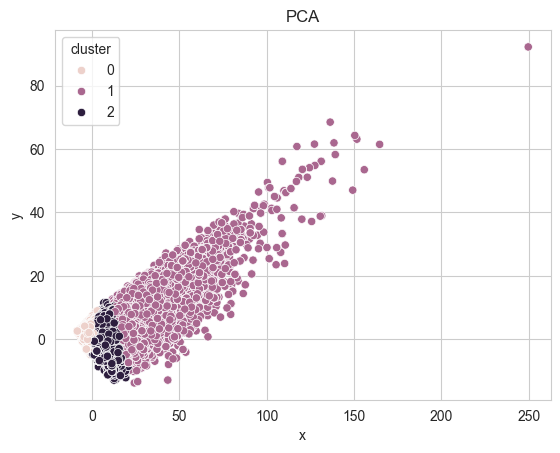

In [659]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(count_vectors_df_)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(count_vectors_df_)
pca3D_df_ = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df_['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df_)
plt.title("PCA")
plt.show()

In [660]:
X_train_text = pca3D_df_.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = pca3D_df_.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5600740006512689


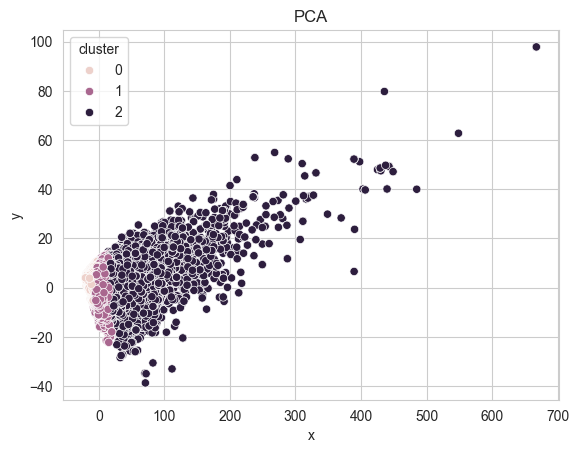

In [661]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(count_vectors_df)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(count_vectors_df)
pca3D_df = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df)
plt.title("PCA")
plt.show()

In [662]:
X_train_all_text = pca3D_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = pca3D_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5502956159583592


In [663]:
lgbm.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lgbm.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5692714675738628


- видим, что сжатие немного ухудшило метрику, но в меньшей степени для 3 столбцов
- теперь создам вектора при помощи TfidfVectorizer

In [664]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1,6), analyzer='char', max_features=100)
tf_vectors_df_ = pd.DataFrame(tf_vectorizer.fit_transform(text).toarray())
X_train_text = tf_vectors_df_.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = tf_vectors_df_.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5686364493057758


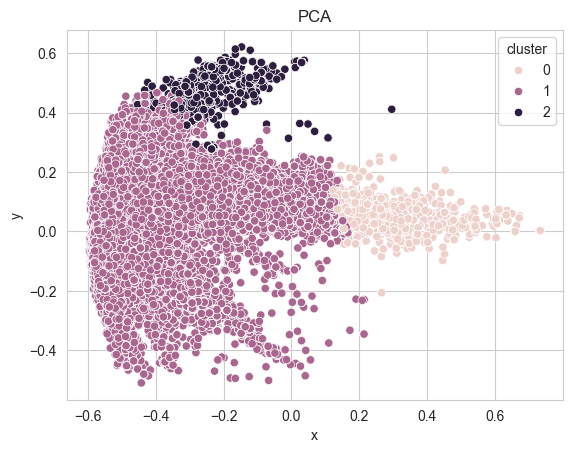

In [665]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(tf_vectors_df_)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(tf_vectors_df_)
pca3D_df_ = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df_['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df_)
plt.title("PCA")
plt.show()

In [666]:
X_train_text = pca3D_df_.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = pca3D_df_.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5567247764563524


In [667]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1,6), analyzer='char', max_features=100)
tf_vectors_df = pd.DataFrame(tf_vectorizer.fit_transform(df.purpose).toarray())
X_train_all_text = tf_vectors_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = tf_vectors_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5760647486557742


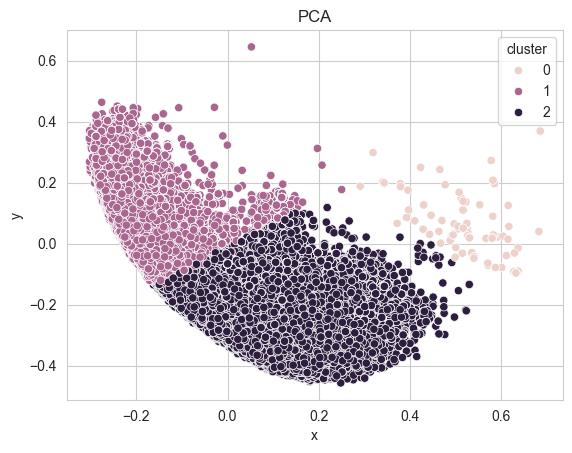

In [668]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(tf_vectors_df)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(tf_vectors_df)
pca3D_df = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df)
plt.title("PCA")
plt.show()

In [669]:
X_train_all_text = pca3D_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = pca3D_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5475906171797706


- результат аналогичен с каунт-векторайзером
- создам вектора при помощи модели word2vec

In [670]:
splitted_text = [x.split(',') for x in text]
mod_w2v = word2vec.Word2Vec(splitted_text, window=3, min_count=1, seed=random_state, workers=2)
vectorized_text = [[mod_w2v.wv.key_to_index.get(x) for x in y] for y in splitted_text]
w2v_df_ = pd.DataFrame(vectorized_text).fillna(0)
X_train_text = w2v_df_.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = w2v_df_.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_text)[:,1]))

ROC_AUC 0.5243681398453275


In [671]:
splitted_text = [x.split(',') for x in df.purpose]
mod_w2v = word2vec.Word2Vec(splitted_text, window=3, min_count=1, seed=random_state, workers=2)
vectorized_text = [[mod_w2v.wv.key_to_index.get(x) for x in y] for y in splitted_text]
w2v_df = pd.DataFrame(vectorized_text).fillna(0)
X_train_all_text = w2v_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_all_text = w2v_df.iloc[df[df.order_id.isin(val_first)].index]
lr.fit(X_train_all_text, y_train)
print('ROC_AUC', roc_auc_score(y_val, lr.predict_proba(X_val_all_text)[:,1]))

ROC_AUC 0.5237168450746577


- итого буду использовать сжатые вектора из трех столбцов, созданных из столбца purpose, обработанные CountVectorizer

In [672]:
#предобработка
text = df[['purpose_sections', 'purpose_categories', 'purpose_lessons']].agg(', '.join, axis=1)
count_vectorizer = CountVectorizer(ngram_range=(1,6), analyzer='char', max_features=100)
count_vectors_df = count_vectorizer.fit_transform(text).toarray()
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10).fit_predict(count_vectors_df)
pca3D = PCA(n_components=3)
pca_3D = pca3D.fit_transform(count_vectors_df)
pca3D_df = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])
#pca3D_df['cluster'] = km_cluster
X_train_text = pca3D_df.iloc[df[df.order_id.isin(train_first)].index]
X_val_text = pca3D_df.iloc[df[df.order_id.isin(val_first)].index]
X_test_text = pca3D_df.iloc[df[df.order_id.isin(test_first)].index]
scaler = StandardScaler()
X_train_text = pd.DataFrame(scaler.fit_transform(X_train_text), columns=scaler.\
    get_feature_names_out(X_train_text.columns), index=X_train_text.index)
X_val_text = pd.DataFrame(scaler.transform(X_val_text), columns=scaler.\
    get_feature_names_out(X_val_text.columns), index=X_val_text.index)
X_test_text = pd.DataFrame(scaler.transform(X_test_text), columns=scaler.\
    get_feature_names_out(X_test_text.columns), index=X_test_text.index)

- теперь займусь подготовкой к обучению других признаков финального датасета:
  - отберу нужные столбцы
  - разделю таким же образом на тренировочную/валидационную/тестовую выборки
  - закодирую и нормализую данные

In [673]:
#предобработка
df.drop('order_id', axis=1, inplace=True)

In [674]:
#предобработка
df[['teacher_sex', 'pupil_knowledgelvl',
 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers', 
 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons', 'status_display',
 'is_confirmed', 'is_cell_phone_confirmed', 'is_remote_lessons', 'show_on_map',
 'send_mailing', 'send_suitable_orders', 'is_edited', 'orders_allowed', 
 'is_display_at_partners', 'enable_auto_assign', 'photo_path', 'sex']] = \
  df[['teacher_sex', 'pupil_knowledgelvl',
 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers',
 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons', 'status_display',
 'is_confirmed', 'is_cell_phone_confirmed', 'is_remote_lessons', 'show_on_map',
 'send_mailing', 'send_suitable_orders', 'is_edited', 'orders_allowed', 
 'is_display_at_partners', 'enable_auto_assign', 'photo_path', 'sex']].astype(str)

In [675]:
#предобработка
num = []
categ = []
for x in df.columns:
    if (df[x].dtype =='object')&(x\
        not in(['purpose', 'purpose_sections', 'purpose_categories', 'purpose_lessons'])):
        categ.append(x)
    if (df[x].dtype in ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']) &\
        (x != 'target'):
        num.append(x)
print("Численный тип данных:", len(num), "cтроковый тип данных:", len(categ))

Численный тип данных: 37 cтроковый тип данных: 21


In [676]:
#предобработка
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_oe=pd.DataFrame(oe.fit_transform(X_train[categ]), columns=oe.get_feature_names_out(X_train[categ]\
        .columns), index=X_train[categ].index)
X_val_oe=pd.DataFrame(oe.transform(X_val[categ]), columns=oe.get_feature_names_out(X_val[categ].columns),\
        index=X_val[categ].index)
X_test_oe=pd.DataFrame(oe.transform(X_test[categ]), columns=oe.get_feature_names_out(X_test[categ].columns),\
        index=X_test[categ].index)
X_train_un = pd.concat([X_train_oe, X_train[num]], axis=1)
X_val_un = pd.concat([X_val_oe, X_val[num]], axis=1)
X_test_un = pd.concat([X_test_oe, X_test[num]], axis=1)
X_train = pd.DataFrame(scaler.fit_transform(X_train_un),\
    columns=scaler.get_feature_names_out(X_train_un.columns), index=X_train_un.index)
X_val = pd.DataFrame(scaler.transform(X_val_un),\
    columns=scaler.get_feature_names_out(X_val_un.columns), index=X_val_un.index)
X_test = pd.DataFrame(scaler.transform(X_test_un),\
    columns=scaler.get_feature_names_out(X_test_un.columns), index=X_test_un.index)

- теперь сделаю отбор признаков:

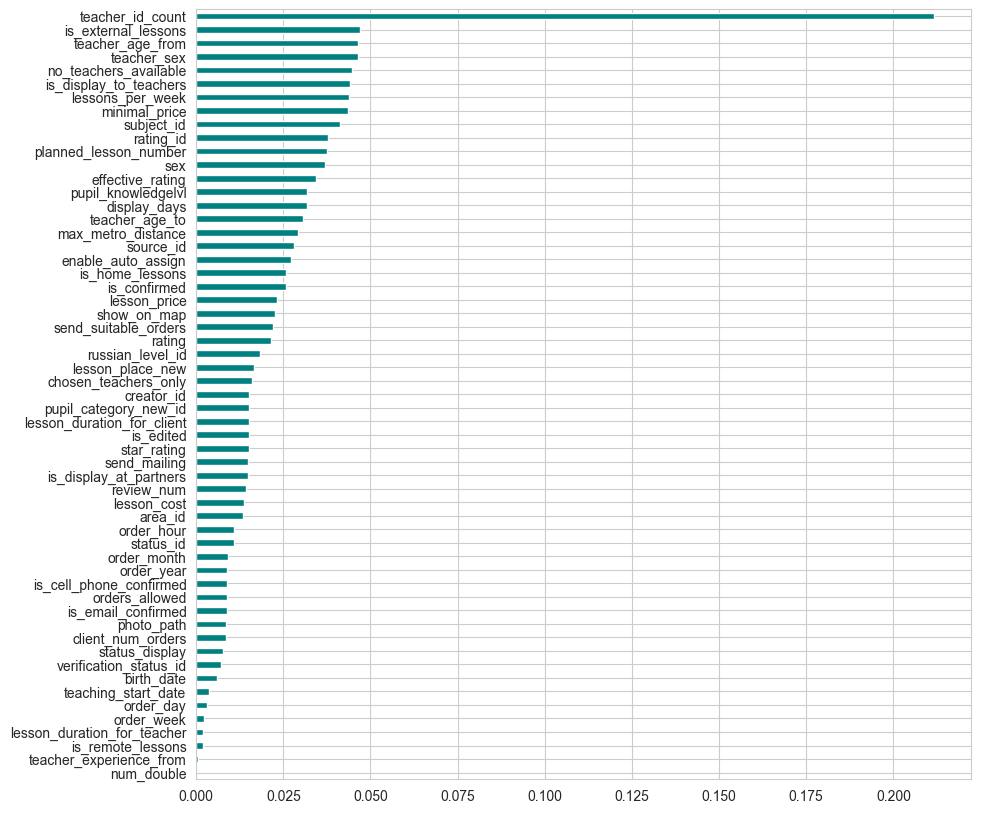

In [677]:
data = df.drop(['order_date', 'purpose', 'purpose_sections', 'purpose_categories', 'purpose_lessons',
 'reg_date'], axis=1)
importances = mutual_info_classif(X_train, y_train)
feature_importances = pd.Series(importances, data.columns[0:len(data.columns)-1])
feature_importances = feature_importances[feature_importances.index!='target']
feature_importances.sort_values().plot(kind='barh', color='teal', figsize=(10, 10))
plt.show()

In [678]:
lgbm.fit(X_train, y_train)
roc_auc_score(y_val, lgbm.predict_proba(X_val)[:,1])

0.6886205918649513

In [679]:
lgbm.fit(X_train.drop(['num_double'], axis=1), y_train)
roc_auc_score(y_val, lgbm.predict_proba(X_val.drop(['num_double'], axis=1))[:,1])

0.6886205918649513

In [680]:
feature_list = X_train.columns.tolist()
lgbm.fit(X_train, y_train)
best_metric = roc_auc_score(y_val, lgbm.predict_proba(X_val)[:,1])
features = []
for x in feature_list:
    lgbm.fit(X_train.drop(x, axis=1), y_train)
    metric = roc_auc_score(y_val, lgbm.predict_proba(X_val.drop(x, axis=1))[:,1])
    if metric > best_metric:
        best_metric = metric
        features.append(x)
print(best_metric, features)       

0.6891675154243538 ['is_cell_phone_confirmed', 'rating']


In [681]:
lgbm.fit(X_train.drop('rating', axis=1), y_train)
roc_auc_score(y_val, lgbm.predict_proba(X_val.drop('rating', axis=1))[:,1])

0.6891675154243538

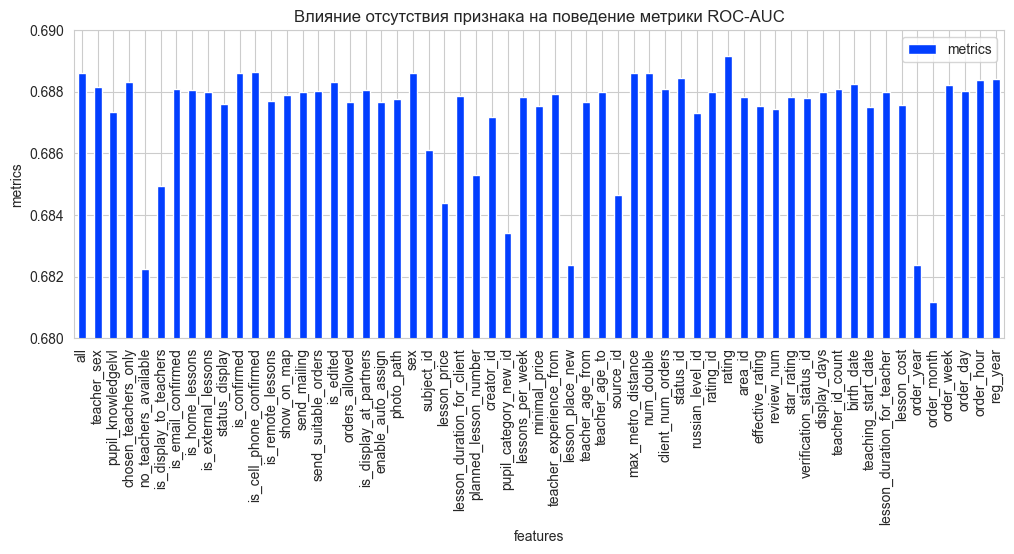

In [682]:
feature_list = X_train.columns.tolist()
metr = []
feat = []
for x in feature_list:
    lgbm.fit(X_train.drop(x, axis=1), y_train)
    metric = roc_auc_score(y_val, lgbm.predict_proba(X_val.drop(x, axis=1))[:,1])
    feat.append(x)
    metr.append(metric)
lgbm.fit(X_train, y_train)
feat_metr = pd.concat([pd.DataFrame(['all'], [roc_auc_score(y_val, lgbm.predict_proba(X_val)[:,1])]),\
    pd.DataFrame(feat, metr)])
feat_metr = feat_metr.reset_index().set_index(feat_metr[0]).drop(0, axis=1)\
    .rename(columns={'index': 'metrics'})
feat_metr.plot(kind='bar', figsize=(12, 4), ylim=(0.68, 0.69), xlabel='features', ylabel='metrics',\
    title = 'Влияние отсутствия признака на поведение метрики ROC-AUC');       

- видим, что возрастание метрики дает отсутствие признака 'rating', это видно также и на визуализации, удалю этот признак

In [683]:
#предобработка
X_train.drop('rating', axis=1, inplace=True)
X_val.drop('rating', axis=1, inplace=True)
X_test.drop('rating', axis=1, inplace=True)

***4. Обучение и валидация моделей***

In [684]:
fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
scores_xgb = cross_val_score(estimator=XGBClassifier(), X=X_train, y=y_train, cv=fold, scoring='roc_auc')
scores_lgbm = cross_val_score(estimator=LGBMClassifier(), X=X_train, y=y_train, cv=fold,\
     scoring='roc_auc')
scores_cat = cross_val_score(estimator=CatBoostClassifier(verbose=0), X=X_train, y=y_train,\
     cv=fold, scoring='roc_auc')
pd.DataFrame({'xgb': scores_xgb, 'lgbm': scores_lgbm, 'cat': scores_cat})

xgb      lgbm       cat
0  0.714221  0.696235  0.733617
1  0.714152  0.695132  0.732643
2  0.710271  0.691180  0.727840
3  0.712026  0.694459  0.731952
4  0.708247  0.691508  0.728762

In [685]:
#предобработка
X_all_train = pd.concat([X_train, X_train_text], axis=1)
X_all_val = pd.concat([X_val, X_val_text], axis=1)

In [686]:
fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
scores_xgb = cross_val_score(estimator=XGBClassifier(), X=X_all_train, y=y_train, cv=fold,\
     scoring='roc_auc')
scores_lgbm = cross_val_score(estimator=LGBMClassifier(), X=X_all_train, y=y_train, cv=fold,\
     scoring='roc_auc')
scores_cat = cross_val_score(estimator=CatBoostClassifier(verbose=0), X=X_all_train, y=y_train,\
     cv=fold, scoring='roc_auc')
pd.DataFrame({'xgb': scores_xgb, 'lgbm': scores_lgbm, 'cat': scores_cat})

xgb      lgbm       cat
0  0.714888  0.697189  0.733001
1  0.712036  0.695364  0.733337
2  0.709927  0.692449  0.727792
3  0.712699  0.694459  0.731580
4  0.710422  0.691584  0.728491

In [687]:
fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
scores_xgb = cross_val_score(estimator=XGBClassifier(), X=X_train_text, y=y_train, cv=fold,\
     scoring='roc_auc')
scores_lgbm = cross_val_score(estimator=LGBMClassifier(), X=X_train_text, y=y_train, cv=fold,\
     scoring='roc_auc')
scores_cat = cross_val_score(estimator=CatBoostClassifier(verbose=0), X=X_train_text, y=y_train,\
     cv=fold, scoring='roc_auc')
pd.DataFrame({'xgb': scores_xgb, 'lgbm': scores_lgbm, 'cat': scores_cat})

xgb      lgbm       cat
0  0.583595  0.576769  0.585018
1  0.581663  0.575384  0.584616
2  0.579909  0.573810  0.582026
3  0.581580  0.576124  0.583954
4  0.582118  0.576568  0.584555

- итого: видно что лучше всего себя на всех фолдах показывает CatBoostClassifier, хотя в принципе разнице в целевой метрике не так уж и велика
  - буду изпользовать все три модели (усредню полученные предсказания) на общих данных (совместно с текстовыми векторами)

In [688]:
#предобработка
lgbm = LGBMClassifier(random_state=random_state)
lgbm.fit(X_all_train, y_train)
lgbm_probs = lgbm.predict_proba(X_all_val)[:,1]
lgbm_preds = lgbm.predict(X_all_val)
print('ROC_AUC for LGBM on validation:', roc_auc_score(y_val, lgbm.predict_proba(X_all_val)[:,1]))
print(classification_report(y_val, lgbm.predict(X_all_val)))

ROC_AUC for LGBM on validation: 0.689174196352633
              precision    recall  f1-score   support

           0       0.72      0.95      0.82     59581
           1       0.58      0.16      0.26     26034

    accuracy                           0.71     85615
   macro avg       0.65      0.56      0.54     85615
weighted avg       0.68      0.71      0.65     85615



In [689]:
#предобработка
cat = CatBoostClassifier(random_state=random_state, verbose=0)
cat.fit(X_all_train, y_train)
cat_probs = cat.predict_proba(X_all_val)[:,1]
cat_preds = cat.predict(X_all_val)
print('ROC_AUC for CAT on validation:', roc_auc_score(y_val, cat.predict_proba(X_all_val)[:,1]))
print(classification_report(y_val, cat.predict(X_all_val)))

ROC_AUC for CAT on validation: 0.6869711881354471
              precision    recall  f1-score   support

           0       0.73      0.93      0.82     59581
           1       0.56      0.20      0.29     26034

    accuracy                           0.71     85615
   macro avg       0.64      0.56      0.55     85615
weighted avg       0.67      0.71      0.66     85615



In [690]:
#предобработка
xgb = XGBClassifier()
xgb.fit(X_all_train, y_train)
xgb_probs = xgb.predict_proba(X_all_val)[:,1]
xgb_preds = xgb.predict(X_all_val)
print('ROC_AUC for XGB on validation:', roc_auc_score(y_val, xgb.predict_proba(X_all_val)[:,1]))
print(classification_report(y_val, xgb.predict(X_all_val)))

ROC_AUC for XGB on validation: 0.6859623031738927
              precision    recall  f1-score   support

           0       0.73      0.94      0.82     59581
           1       0.56      0.19      0.28     26034

    accuracy                           0.71     85615
   macro avg       0.64      0.56      0.55     85615
weighted avg       0.68      0.71      0.65     85615



In [691]:
mean_probs = (lgbm_probs+cat_probs+xgb_probs)/3
mean_preds = (lgbm_preds+cat_preds+xgb_preds)/3
mean_preds = np.where(mean_preds>=.5, 1, 0)
print('ROC_AUC for 3 models on validation:', roc_auc_score(y_val, mean_probs))
print(classification_report(y_val, mean_preds))

ROC_AUC for 3 models on validation: 0.6918995309279189
              precision    recall  f1-score   support

           0       0.72      0.94      0.82     59581
           1       0.58      0.18      0.27     26034

    accuracy                           0.71     85615
   macro avg       0.65      0.56      0.55     85615
weighted avg       0.68      0.71      0.65     85615



- итого на валидации по усредненным предсказаниям трех моделей на общих данных была достигнута целевая метрика 0.692
- теперь посмотрю на коэффициенты shap, разбор сделаю только для модели LGBMClassifier:

In [692]:
explainer_for_lgbm = shap.Explainer(lgbm, X_all_train)
shap_values_lgbm = explainer_for_lgbm(X_all_train, check_additivity=False)

100%|===================| 693864/694139 [35:09<00:00]        

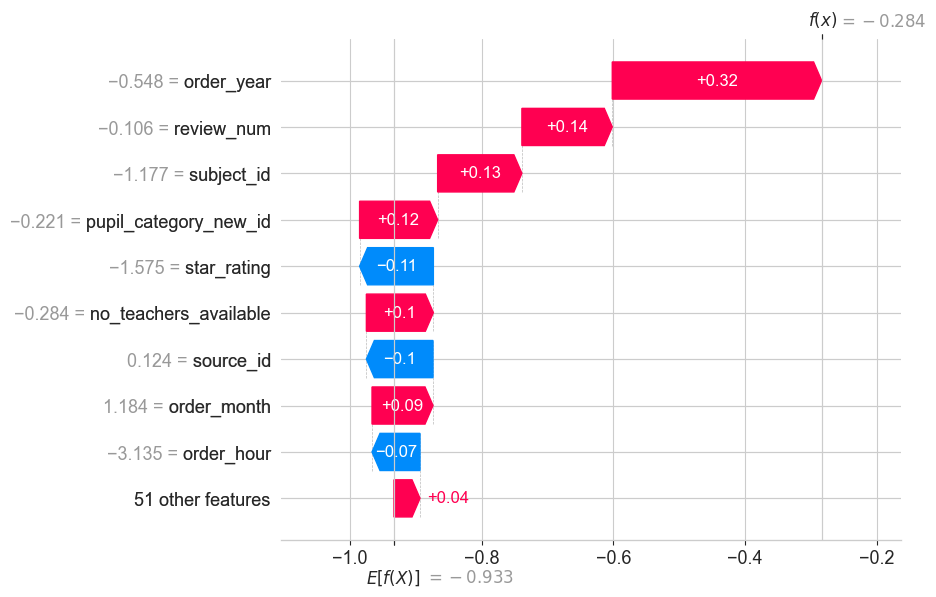

In [693]:
shap.plots.waterfall(shap_values_lgbm[0])

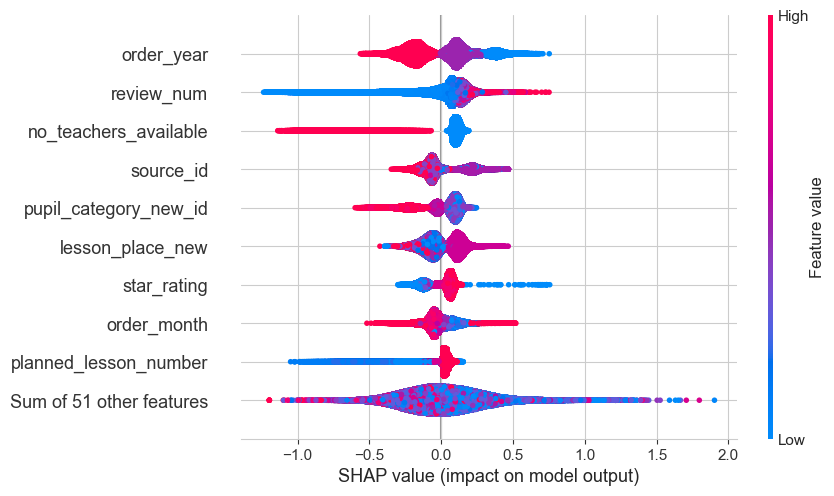

In [694]:
shap.plots.beeswarm(shap_values_lgbm)

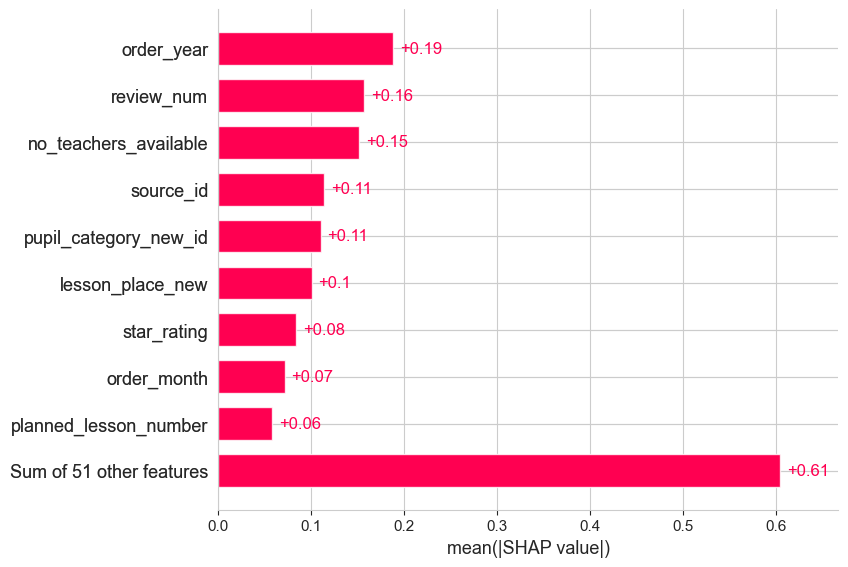

In [695]:
shap.plots.bar(shap_values_lgbm)

- итого по последнему графику можно увидеть какие признаки являются для прогнозов модели LGBMClassifier наиболее важными: на нем показаны усредненные результаты shap-значений - это год оформления заявки, количество отзывов и т.д., на графике beeswarm, можно заметить следующие взаимосвязи между признаками и прогнозами модели, например: чем больше год оформления заявки, тем больше неоплаченных заявок мы имеем, чем меньше количество отзывов, тем больше неоплаченных заявок.

***5. Тестирование:***

- проведу тестирование на усредненных предсказаниях трех моделей градиентного бустинга:

In [696]:
#предобработка
X_all_test = pd.concat([X_test, X_test_text], axis=1)
lgbm_probs_test = lgbm.predict_proba(X_all_test)[:,1]
lgbm_preds_test = lgbm.predict(X_all_test)
cat_probs_test = cat.predict_proba(X_all_test)[:,1]
cat_preds_test = cat.predict(X_all_test)
xgb_probs_test = xgb.predict_proba(X_all_test)[:,1]
xgb_preds_test = xgb.predict(X_all_test)
mean_probs_test = (lgbm_probs_test+cat_probs_test+xgb_probs_test)/3
mean_preds_test = (lgbm_preds_test+cat_preds_test+xgb_preds_test)/3
mean_preds_test = np.where(mean_preds_test>=.5, 1, 0)
print('ROC_AUC for 3 models on test:', roc_auc_score(y_test, mean_probs_test))
print(classification_report(y_test, mean_preds_test))

ROC_AUC for 3 models on test: 0.6882026042230923
              precision    recall  f1-score   support

           0       0.72      0.94      0.82     60190
           1       0.58      0.17      0.26     26627

    accuracy                           0.71     86817
   macro avg       0.65      0.56      0.54     86817
weighted avg       0.68      0.71      0.65     86817



- полученная метрика незначительно уступает метрике, полученной на валидации
- теперь проведу калибровку полученных вероятностей (с использованием логистической и изотонической регрессий). Калибровку не стоит проводить на тех же данных, что применялись для обучения первой модели. Это приведет к смещению, так как производительность модели на его обучающих данных будет выше, чем на новых.
  - для этого обучу калибратор на основе обеих регрессий, воспользовавшись результирующими данными предсказаний моделей:

In [697]:
logistic_regress = LogisticRegression().fit(mean_probs.reshape(-1, 1), y_val)
prb_logistic_regress = logistic_regress.predict_proba(mean_probs_test\
    .reshape(-1, 1))[:, 1]

In [698]:
isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip')\
    .fit(mean_probs, y_val) 
prb_isotonic_regress = isotonic_regress.predict(mean_probs_test)

- для оценки результатов посчитаю ожидаемую ошибку калибровки:

In [699]:
def expected_calibration_error(y, proba, bins = 'fd'):
  bin_count, bin_edges = np.histogram(proba, bins = bins)
  n_bins = len(bin_count)
  bin_edges[0] -= 1e-8
  bin_id = np.digitize(proba, bin_edges, right = True) - 1
  bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
  bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
  bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
  return ece

In [700]:
expected_calibration_error(y_test, prb_logistic_regress)

0.020061300709512078

In [701]:
expected_calibration_error(y_test, prb_isotonic_regress)

0.011447315950371769

In [702]:
roc_auc_score(y_test, prb_isotonic_regress)

0.6880274284847023

- итого: изотоническая регрессия показала самое маленькое отклонение от реальной вероятности в 1%, это и будет наиболее подходящая модель с точки зрения калибровки.

***6. Общие выводы по проекту:***

1. Открыты три датасета с данными (информация о заявках, информация о репетиторах, подходящие по фильтру репетиторы). Убраны полные дубликаты строк (949 в трех датасетах), данные проанализированы по количеству пропущенных значений. Признаки, содержащие временные отметки, переведены во временной тип.
2. Проведен ***разведовательный*** анализ данных:
  - в датасете с информацией о заявках выявлено:
    -  максимальные пики в распределении даты оформления заявок приходятся на начало осени, либо на начало года ("осенние" значения больше), аналогичная ситуация и с датами начала занятий, в принципе схожая ситуация из датами платежей, есть сравнительно небольшой их рост в сентябре-октябре 2023 года, по сравнению с аналогичными периодами за 2021-2022гг
  - согласно данным столбцов дата создания заявки и дата начала, временной отчет начинается с 1 сентября 2021 года, заканчивается 5-7 ноября 2023г
  - удалены строки, id которых равно 3211265, 3342337, 3605505, так как оно задублировано в других численных признаках
  - распределение предметов обучения: лидируют предметы, закодированные цифрами 8, 2, 1
  - распределение цены занятия: лидируют 1500, 1000, 500, 0
  - распределение длительности занятия: безоговорочно лидирует 60 минут
  - распределение количества запланированных уроков: лидирует 10 уроков
  - распределение возраста учеников: лидируют возраста, относящиеся к средней школе
  - распределение количества уроков в неделю: лидируют - 3, 4, 5, 0.
  - распределение мест проведения занятий: лидируют значения - 4, 2, 1
  - распределение уровня знаний ученика: лидирует нулевой уровень.
  - распределение источников создания заявки: лидируют - 23, 14, 16.
  - распределение максимального времени до метро: лидируют 30, 20, 15
  - пол репетитора: по данным заказчика значение 1 - мужской, 2-женский, 0 и 3 -"пол неизвестен", изменила этот столбец установив единое значение 0 для неизвестных значений
  - по данным признакам проведена следующая предобработка:
    - в категориях  с минимальной ценой занятия, ценой занятия и максимальным расстоянием до метро присутствуют выбросы. По данным от заказчика цена занятия не может быть более 10000, а время ограничила 100 минутами, заменила выбросы на медианные значения по категории
    - нулевые значения в полях: количество уроков в неделю, цена занятия и минимальная цена занятия говорят о том, что данные столбцы просто не были заполнены - закрыла их медианными значениями по категории, а нули в столбце с минимальной ценой вторым по популярности значением, так как медианна или мода там нулевая
    - заменила выбросы в графе возраст ученика (по крайней мере до 5 лет) на медианные значения по категории
    - пропуске в данных о возрасте ученика и максимальной дистанцией до метро заполнила медианным значением по категории
  - так как на территории всей страны насчитывается всего 393 станции метро, а в столбце home_metro_id их в 6 раз больше, и восстановить данную информацию не представляется возможным, удалила столбец home_metro_id
  - по полученной информации столбцы working_teacher_id и additional_status_id несут в себе информацию из будущего и по этой причине были удалены
  - подавляющее количество значений в столбце creator_id встречается 1 раз, значений, встречающихся более 100 раз, всего 83 (скорее всего это сотрудники колл-центра), то есть основную массу заявок регистрируют сами пользователи, пропуски в них заполнила заглушкой 0
  - распределение данных о начальном опыте репетитора: основное значение - от 0 лет
  - распределение данных о максимальном опыте учителя: подавляющее количество имеет значение 0 лет (более миллиона строк - видимо просто эти данные не проставлялись), следующие по популярности значения носят явно "выбросный" характер(100 лет), так как этот столбец не несет никакой информации, я его удалила
  - данные о минимальном/максимальном возрасте учителя содержат выбросы, возрастной диапазон ограничила интервалом от 16 до 90 лет, другие значения заполнила вторым по популярности ответом клиента
  - судя по распределению столбца "не предлагать репетиторов кроме выбранных" основная масса клиентов идет не к конкретному учителю
  - судя по данным в столбце "на заявку нет подходящих репетиторов" в большинстве случаев это не так, а те же заявки где значение является положительным в основном закрыты
  - по данным о желании клиента получать отклики об учителях: основная чать согласна на это
  - согласно визуализации с частотой появления id клиента в заявках, можно сделать вывод, что основная масса потребителей обращается только 1 раз
  - столбец prefered_teacher_id состоит из одних пропусков и несет информацию из будущего, удалила его
  - столбец с оригинальными id заявок содержит пропуски (что вполне логично, так как не все заявки имеют дубликаты), тогда как некоторые заявки имеют их до 100 штук
  - в данном датасете встречаются тектовые данные, заполнила пропущенные значения (заглушка "No"), написала функцию для обработки текста (приведение в нижний регистр, удаление общих и стоп-слов, удаление пунктуации, токенезация и лематизация)
  - для данного столбца с целью занятий я применила два способа предобработки:
    - сделала из него три новых столбца: ***purpose_sections***, содержаший инфо о предметах, ***purpose_categories***, инфо о категориях учеников, ***purpose_lessons***, инфо о целях занятий, соответственно провела предобработку текстов
    - обработала этот столбец при помощи паттернов
  - столбец с дополнительной информацией в основном содержит в себе дублирующую информацию из других столбцов датасета(опыт, возраст, пол репетитора, формат занятий и т.п.), мною было принято решение его удалить
  - относительно столбца с комментариями, в нем около половины пропущенных значений, и в основном служебная информация от операторов колл-центра. Единственным важным элементном в этом столбце я нашла отсылки на оригинальный номер заявки и таким образом удается восстановить порядка 60 тыс пропущенных значений в столбце original_order_id. Столбец comment удален
  - самую большую частоту занимают значения таргета 16 и 7 (и оба они означают закрытую заявку) - это 84 процента от всего объема. Так как у нас задача бинарной классификации из данного столбца я создала бинарный столбец ***target***, в котором к положительному классу (заявка оплачена) отнесу (по информации от заказчика) значения 5, 6, 13, 15; а к отрицательному все остальные значения. Столбец status_id, соотвественно был удален.
  - так как столбец lesson_place практически полностью состоит из пропусков, он был удален
  - Проведен ***анализ*** датасета с заявками:
  - Выводы по группировке таргета:
    - средняя цена урока при оплаченной заявке выше, как и минимальная цена, что говорит о "серьезности" намерений потребителя при начальном оформлении заявки
    - также при оплаченной заявке больше среднее общее количество занятий и среднее количество уроков в неделю
    - несмотря на присутствие большого количества пропущенных значений, закрытых нолями, в столбцах средний опыт, средний мин и макс возраст учителя, видно, что опять же эти значения выше именно у положительного таргета, ну и средняя общая оплата соотвественно выше тоже у положительного класса
  - по анализу временных зависимостей сделан вывод, что точки максимума на графике тренда в разные годы относятся к началу учебного и нового года, а минимума к концу года
  - по критерию оценки Дики-Фуллера делаю вывод, что данный временной ряд относится к классу ТS (ряды, становящиеся стационарными после вычитания из них детерминированного тренда)
  - также графики автокорреляции демонстрируют, что колебания целевой переменной укладываюся в период равный 14 дням
  - Составлен портрет типичного ученика: 
    - 10 лет
    - с начальным уровнем знаний
    - цель занятий: помощь в школьной программе
    - изначально готов на 10 занятий 3 раза в неделю по цене в 1000 руб
    - готов ехать до репетитора в течение 30 минут
    - готов получать отклики репетиторов
  - Портрет наиболее востребованного преподавателя:
    - учитель математики
    - пол не важен
    - опыт от 5 лет
    - возраст 25 - 50 лет
    - без конкретизации личности
  - так как данные после объединения таблиц будут группироваться по колонке original_order_id, если в ней пропущенное значение значит заявка без дубля и сама является оригиналом, все эти пропуски заполнила данными из столбца id заявки
  - так как заказчик поставил задачу разметить дубли по порядку их появления:
  - отсортировала таблицу по возрастанию даты оформления заявки, создала столбец ***num_double***, который содержит порядковые номера дублей, в соответствии со временем их появления. Установила пороговое значение для количества дублей, равное 5
  - при наличии хотя бы одного положительного значения в столбце таргет каждой из групп присвоила всей группе значение 1
  - так же создала новый столбец ***client_num_orders***, характеризующий количество заявок от одного клиента (столбец с айди клиента было принято решение удалить, как потенциально дающий вероятность утечки данных)
  - столбцы amount_to_pay, estimated_fee, first_lesson_date, payment_date несут в себе информацию из прошлого и были удалены
  - ***Разведовательный анализ*** датасета с информацией о репетиторах:
  - были удалены столбцы status_relevant_date, rules_confirmed_date и free_time_relevance_date, так как они состоят практически из одних пропусков (более 80 проц)
  - столбец с датой обновления содержит в основном даты конца 2022 начала 2023 года, конечно есть совсем небольшое количество данных за прошлые годы, но никакой полезной информации он не несет, поэтому я его удалила
  - столбец с датой регистрации преподов в системе показывает планомерный рост с 2008 по 2020 год, потом уровень вышел на некое плато со взлетами и падениями, но к концу 2023 года мы опять видим максимальные показатели
  - столбец с датой рождения репетитора: содержит выбросы, которыя я как и в датасете с заявками я ограничила возрастным интервалом 17-90 лет (или 1933-2006 г.р.)
  - аналогичная ситуация и со столбцом о начале преподавания (поставила минимальный порог - 1950 год), распределение "невыбросных" значений с конца семидесятых по настоящее время
  - удалила столбцы status_school_id, status_college_id, status_school_id.1, status_college_id.1, status_school_id.2, status_college_id.2, is_pupils_needed, passport_id, is_individual, status_institution_id состоящие практически из одних пропусков.
  - удалила столбцы: is_confirmed.1, is_confirmed.2, status_id.1, status_id.2, lesson_duration.1, lesson_duration.2, lesson_cost.1, lesson_cost.2, status_display.1, status_display.2, russian_level_id.1, russian_level_id.2, home_country_id.1, home_country_id.2, так как они являются полными дубликатами основных столбцов
  - столбец распределение времени занятия - превалирует 60 мин
  - столбец распределение стоимости урока - большее количество данных не проставлено, затем следует 1000, 500
  - столбец распределение значений статуса - превалирует значение 5
  - столбец распределение значений уровня русского - большее количество имеет макс уровень, следующее значение: уровень не проставлен
  - столбец распределение значений страны происхождения - подавляющее количество у значения 7 (видимо РФ), удалю столбец так как это значение подавляет все остальные
  - столбец распределение значений рейтинг id - лидирует значение 15
  - столбец распределение значений рейтинга - лидирует значение 5
  - столбец распределение пола учителей - превалирует женский (2), затем мужской (1), значения 0 и 3 объединю в одно 0 - пол не проставлен
  - столбец распределение значений верификационного статуса - лидирует значение 0
  - столбец распределение отзывов - лидирует 0 значение (отсутствие таковых)
  - так как столбец прошлый рейтинг для пользователей отличается от столбца рейтинг для пользователей только на 2% - удалила его
  - распределение столбца сумма к выплате имеет три частоты распределения, одна из которых (0) занимает подавляющее значение, поэтому данный столбец не несет никакой дополнительной информации и я удалила его
  - столбцы external_comments, external_comments.1, external_comments.2 - аналогичны ( содержащие в основном информацию о конкретных адресах) имеют 71% пропусков, и ониудалены за неинформативность; 
  - столбцы information, information.1, information.2 - аналогичны, имеют 51% пропусков, но так как они несут информацию о процессе обучения удалила только последние два из них 
  - столбцы status_relevant_date.1, status_relevant_date.2 - аналогичны, имеют 85% пропусков и были удалены
  - столбец с комментариями операторов comments имеет 85% пропусков и был удален
  - столбец pupil_needed_date имеет 90% пропусков и был удален, аналогичная ситуация и со столбцами: remote_comments, partner_id 
  - столбец photo_path: пропуски и значения без фото заменены 0, присутствие фото - обозначено 1
- был составлен портрет типичного преподавателя на платформе:
  - Итак, типичный репетитор на платформе это:
  - женщина
  - возраст 30+
  - преподавательский стаж около 11 лет
  - предпочитающая заниматься онлайн
  - не назначившая стоимость занятия
  - с подтвержденным статусом на платформе
  - статус id = 5, рейтинг id = 15, рейтинг = 5 (значения статуса и рейтингов не известны)
  - ее статус отображен на платформе
  - не готова заниматься на дому (хотела удалить этот столбец, так как думала он коллинеарен с удаленными уроками, но посмотрела, что у них разное распределение поняла, что это разные понятия: первое он и офлайн, второе у себя на дому или нет)
  - отправляющая подходящие заявки
  - со звездным рейтингом около 4
  - без отзывов
  - ее кандидатура размещена также и на других платформах
- В датасете с подходящими по фильтру репетиторами:
  - столбец с результатами контактов операторов с репетиторами содержит в основном уточняющую переписку, информация из которой разрознена, также в этом столбце 63% пропусков, удалила его за неинформативность
- ***Объединение таблиц***:
  - для этого сначала объединила таблицы "Информация по репетиторам" и "Подходящие по фильтру репетиторы" по общему столбцу teacher_id, затем сгруппировала получившуюся таблицу по столбцу order_id, затем объединила получившийся столбец со столбцом с информацией по заявкам
- 3. В разделе с ***отбором признаков*** для финального датасета:
  - проанализировала кореляцию признаков и сделала выводы, что предполагаемая стоимость урока достаточно хорошо связана с планируемым общим количеством занятий и количеством занятий в неделю, таргет относительно неплохо корелирует с айди клиента, источником заполнения заявки и рейтинговыми признаками
  - создала новые признаки из имеющихся временных отметок (год/месяц/день/час оформления заявки и год регистрации преподавателя на платформе)
  - чтобы разделить датасет на тренировочную/валидационную/тестовую части и при этом не разделять группы дублей, я создала список с названиями первых строк каждой группы, затем разделила их в нужных пропорциях и соотвественно по ним составила тренировочную/валидационную и тестовую выбоки:
  - попробовала разные методы векторизации текстов, причем на двух способач предобработки столбца purpose (обработка при помощи паттернов и разбиение его на три столбца):
    - векторизация, с использованием словаря индексов
    - при помощи countvectorizer(tfidf)
    - модели word2vec
  - по полученным результатам выбрала сжатые вектора из трех столбцов, созданных из столбца purpose, обработанные CountVectorizer
- остальные данные также разделила на тренировочную/валидационную/тестовую части, закодировала и нормализовала
- определила, что возрастание метрики дает отсутствие признака 'rating', поэтому удалила его
- 4. ***Обучение и валидация моделей***
  - провела кроссвалидацию трех моделей(LGBMClassifier, CatBoostClassifier, XGBClassifier) и приняла решение иcпользовать все три модели (усреднила полученные предсказания) на общих данных (совместно с текстовыми векторами)
  - итого на валидации по усредненным предсказаниям трех моделей на общих данных была достигнута целевая метрика 0.692
  - по графику усредненных shap-значений можно увидеть какие признаки являются для прогнозов модели LGBMClassifier наиболее важными: это год оформления заявки, количество отзывов и т.д., на графике beeswarm, можно заметить следующие взаимосвязи между признаками и прогнозами модели, например: чем больше год оформления заявки, тем больше неоплаченных заявок мы имеем, чем меньше количество отзывов, тем больше неоплаченных заявок
- 5. ***Тестирование:***
  - полученная метрика на тесте незначительно уступает метрике, полученной на валидации
  - провела калибровку полученных вероятностей (с использованием логистической и изотонической регрессий), для этого обучила калибратор на основе обеих регрессий, воспользовавшись результирующими данными предсказаний моделей:
  - изотоническая регрессия показала самое маленькое отклонение от реальной вероятности в 1%, это и будет наиболее подходящая модель с точки зрения калибровки
  